<a href="https://colab.research.google.com/github/Boonyaratt/LGBM_recommendation/blob/master/Notebooks/fixed_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
from datetime import datetime, timedelta
from dateutil import easter
from typing import Dict, Text
import os, kagglehub
import lightgbm as lgb
import heapq
from functools import lru_cache
from collections import defaultdict
from xgboost import XGBRanker
import pathlib
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
!mkdir Dataset

In [3]:
os.environ["KAGGLEHUB_CACHE"] = "/content/Dataset"  # exact case
pathlib.Path("/content/Dataset").mkdir(parents=True, exist_ok=True)

kaggle_path = kagglehub.dataset_download("frtgnn/dunnhumby-the-complete-journey")
print(kaggle_path)

100%|██████████| 124M/124M [00:00<00:00, 158MB/s]

Extracting files...


/content/Dataset/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1


In [20]:
# path = "/kaggle/input/dunnhumby-the-complete-journey/"
path = "/content/Dataset/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1/"

campaign_desc = pd.read_csv(path + "campaign_desc.csv")
campaign_table = pd.read_csv(path + "campaign_table.csv")
coupon_redempt = pd.read_csv(path + "coupon_redempt.csv") ## 1 counpon_unc can have multiple product_id: 556 nunique from 2318
coupon = pd.read_csv(path + "coupon.csv")
product = pd.read_csv(path + "product.csv")
transaction_data = pd.read_csv(path + "transaction_data.csv")
dem = pd.read_csv(path + "hh_demographic.csv")
print("DataFrames loaded successfully!")
print(f"campaign_desc shape: {campaign_desc.shape}")
print(f"campaign_table shape: {campaign_table.shape}")
print(f"coupon_redempt shape: {coupon_redempt.shape}")
print(f"coupon shape: {coupon.shape}")
print(f"product shape: {product.shape}")
print(f"transaction_data shape: {transaction_data.shape}")

print("Headers for each dataset:")
print("=" * 50)

datasets = {
    'campaign_desc': campaign_desc,
    'campaign_table': campaign_table,
    'coupon_redempt': coupon_redempt,
    'coupon': coupon,
    'product': product,
    'transaction_data': transaction_data
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"Columns: {list(df.columns)}")

DataFrames loaded successfully!
campaign_desc shape: (30, 4)
campaign_table shape: (7208, 3)
coupon_redempt shape: (2318, 4)
coupon shape: (124548, 3)
product shape: (92353, 7)
transaction_data shape: (2595732, 12)
Headers for each dataset:

campaign_desc:
Columns: ['DESCRIPTION', 'CAMPAIGN', 'START_DAY', 'END_DAY']

campaign_table:
Columns: ['DESCRIPTION', 'household_key', 'CAMPAIGN']

coupon_redempt:
Columns: ['household_key', 'DAY', 'COUPON_UPC', 'CAMPAIGN']

coupon:
Columns: ['COUPON_UPC', 'PRODUCT_ID', 'CAMPAIGN']

product:
Columns: ['PRODUCT_ID', 'MANUFACTURER', 'DEPARTMENT', 'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT']

transaction_data:
Columns: ['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY', 'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO', 'COUPON_DISC', 'COUPON_MATCH_DISC']


##2

### ลดจำนวนข้อมูล
จำกัดวัน - จำนวนผู้ใช้ ที่ใช้ใน dataset

In [21]:
transaction_data.groupby("BASKET_ID")["DAY"].nunique().value_counts()

DAY
1    276484
Name: count, dtype: int64

In [22]:
N_HH = 800
top_hh = (transaction_data["household_key"].value_counts().head(N_HH).index.astype(str))
transaction_data = transaction_data[transaction_data["household_key"].astype(str).isin(top_hh)].copy()
campaign_table   = campaign_table[campaign_table["household_key"].astype(str).isin(set(top_hh))].copy()
coupon_redempt   = coupon_redempt[coupon_redempt["household_key"].astype(str).isin(set(top_hh))].copy()

# ============================ #
WINDOW_DAYS = 250

min_day_all = int(transaction_data["DAY"].min()) #1
max_day_all = int(transaction_data["DAY"].max()) #711
start_day = max(min_day_all, max_day_all - WINDOW_DAYS + 1)
end_day   = max_day_all

keep_hh = set(transaction_data["household_key"].astype(str).unique())
campaign_table = campaign_table[campaign_table["household_key"].astype(str).isin(keep_hh)].copy()
coupon_redempt = coupon_redempt[coupon_redempt["household_key"].astype(str).isin(keep_hh)].copy()

# remove product_id not it transaction
keep_products = set(transaction_data["PRODUCT_ID"].astype(str).unique())
product = product[product["PRODUCT_ID"].astype(str).isin(keep_products)].copy()

In [23]:
print(f"Using DAY window [{start_day}, {end_day}]")

Using DAY window [462, 711]


In [24]:
print("transaction_data:", transaction_data.shape, "campaign_desc:", campaign_desc.shape,
      "campaign_table:", campaign_table.shape, "coupon_redempt:", coupon_redempt.shape,
      "coupon:", coupon.shape, "product:", product.shape)

transaction_data: (1751648, 12) campaign_desc: (30, 4) campaign_table: (5077, 3) coupon_redempt: (2073, 4) coupon: (124548, 3) product: (73102, 7)


In [25]:
max_day_all

711

###Change Data type


In [26]:
coupon['COUPON_UPC'] = coupon['COUPON_UPC'].astype(str)
coupon['CAMPAIGN'] = coupon['CAMPAIGN'].astype(str)
coupon['PRODUCT_ID'] = coupon['PRODUCT_ID'].astype(str)

campaign_desc['CAMPAIGN'] = campaign_desc['CAMPAIGN'].astype(str)

campaign_table['CAMPAIGN'] = campaign_table['CAMPAIGN'].astype(str)
campaign_table['household_key'] = campaign_table['household_key'].astype(str)

coupon_redempt['COUPON_UPC'] = coupon_redempt['COUPON_UPC'].astype(str)
coupon_redempt['CAMPAIGN'] = coupon_redempt['CAMPAIGN'].astype(str)
coupon_redempt['household_key'] = coupon_redempt['household_key'].astype(str)

transaction_data['household_key'] = transaction_data['household_key'].astype(str)
transaction_data['STORE_ID'] = transaction_data['STORE_ID'].astype(str)
transaction_data['PRODUCT_ID'] = transaction_data['PRODUCT_ID'].astype(str)
transaction_data['BASKET_ID'] = transaction_data['BASKET_ID'].astype(str)

coupon_redempt['PROMO_KEY'] = coupon_redempt['COUPON_UPC'] + '|' + coupon_redempt['CAMPAIGN']
coupon['PROMO_KEY'] = coupon['COUPON_UPC'] + '|' + coupon['CAMPAIGN']

product['PRODUCT_ID'] = product['PRODUCT_ID'].astype(str)
product['DEPARTMENT'] = product['DEPARTMENT'].astype(str)
product['MANUFACTURER'] = product['MANUFACTURER'].astype(str)

dem['household_key'] = dem['household_key'].astype(str)


###merge

In [27]:
def normalize_age_band(x: str) -> str:
    if not isinstance(x, str): return 'UNK'
    x = x.strip().upper()
    # ตัวอย่างช่วงที่พบ: '19-24', '25-34', '35-44', '45-54', '55-64', '65+'
    if '19-24' in x: return '19_24'
    if '25-34' in x: return '25_34'
    if '35-44' in x: return '35_44'
    if '45-54' in x: return '45_54'
    if '55-64' in x: return '55_64'
    if '65' in x:   return '65P'
    return 'UNK'

dem['AGE_BAND'] = dem.get('AGE_DESC', np.nan).map(normalize_age_band)
dem = dem[['household_key','AGE_BAND']]

In [28]:
#creaaate new promo dataset | promo catlog
promo_catalog = coupon.merge(
    campaign_desc[['CAMPAIGN','START_DAY','END_DAY']],
    on='CAMPAIGN', how='left'
)[['PROMO_KEY','COUPON_UPC','CAMPAIGN','PRODUCT_ID','START_DAY','END_DAY']]

promo_catalog.head()


PROMO_KEY   COUPON_UPC CAMPAIGN PRODUCT_ID  START_DAY  END_DAY
0   10000089061|4  10000089061        4      27160        372      404
1   10000089064|9  10000089064        9      27754        435      467
2  10000089073|12  10000089073       12      28897        477      509
3  51800009050|28  51800009050       28      28919        259      320
4  52100000076|25  52100000076       25      28929        659      691

In [10]:
hh_campaigns = campaign_table[['household_key','CAMPAIGN']].drop_duplicates()
hh_promos = hh_campaigns.merge(
    promo_catalog[['CAMPAIGN','PROMO_KEY','START_DAY','END_DAY']],
    on='CAMPAIGN', how='left'
).dropna(subset=['PROMO_KEY'])

hh_promos.head()

household_key CAMPAIGN       PROMO_KEY  START_DAY  END_DAY
0            27       26  51111037233|26        224      264
1            27       26  51111037233|26        224      264
2            27       26  51111037233|26        224      264
3            27       26  51111037233|26        224      264
4            27       26  51111037233|26        224      264

In [29]:
# dic represent which set of products are contained in each promotion
promo_to_products = (
    coupon[['COUPON_UPC','CAMPAIGN','PRODUCT_ID']]
    .assign(PROMO_KEY=lambda df: df['COUPON_UPC'] + '|' + df['CAMPAIGN'])
    .groupby('PROMO_KEY')['PRODUCT_ID']
    .apply(lambda s: set(s.astype(str)))
    .to_dict()
)

In [31]:
coupon_prod = coupon.merge(
    product[['PRODUCT_ID','DEPARTMENT','BRAND']],
    on='PRODUCT_ID', how='left'
).assign(PROMO_KEY=lambda df: df['COUPON_UPC'] + '|' + df['CAMPAIGN'])
coupon_prod['DEPARTMENT'] = coupon_prod['DEPARTMENT'].fillna('UNK')
coupon_prod['BRAND'] = coupon_prod['BRAND'].fillna('UNK')

promo_stats = coupon_prod.groupby('PROMO_KEY').agg({
    'DEPARTMENT': 'nunique',  # จำนวน departments
    'BRAND': 'nunique',       # จำนวน brands
    'PRODUCT_ID': 'count'     # จำนวนสินค้า
}).rename(columns={
    'DEPARTMENT': 'feat_num_depts',
    'BRAND': 'feat_num_brands',
    'PRODUCT_ID': 'feat_num_products'
})


In [33]:
promo_pop = coupon_redempt['PROMO_KEY'].value_counts().to_dict()

In [34]:
redempt_by_hh_day = (
    coupon_redempt.groupby(['household_key','DAY'])['PROMO_KEY']
    .apply(set).to_dict()
)

In [35]:
coupon_redempt= coupon_redempt.merge(
    coupon[['COUPON_UPC', 'PRODUCT_ID']],
    on='COUPON_UPC',
    how='left'
)

coupon= coupon.merge(
    campaign_desc[['START_DAY', 'END_DAY', 'CAMPAIGN']],
    on='CAMPAIGN',
    how='left'
)

coupon = coupon.merge(
    product[['PRODUCT_ID', 'DEPARTMENT', 'MANUFACTURER']],
    on='PRODUCT_ID',
    how='left'
)

### create timestamp

In [36]:
def create_timestamp(day, trans_time):
    base_date = datetime(2010, 3, 24)  # Arbitrary base date
    date_part = base_date + timedelta(days=int(day) - 1)

    # Convert TRANS_TIME to time
    hours = int(trans_time) // 100
    minutes = int(trans_time) % 100
    time_part = timedelta(hours=hours, minutes=minutes)

    return date_part + time_part

# Add timestamp to transaction_data
transaction_data['timestamp'] = transaction_data.apply(
    lambda row: create_timestamp(row['DAY'], row['TRANS_TIME']), axis=1
)

ts = transaction_data["timestamp"]
transaction_data["hour"]        = ts.dt.hour.astype("Int64")

transaction_data["dayofweek"]   = ts.dt.dayofweek.astype("Int64")    # 0=Mon .. 6=Sun
transaction_data["is_weekend"]  = transaction_data["dayofweek"].isin([5,6]).astype("int64")

transaction_data["day"]         = ts.dt.day.astype("Int64")
transaction_data["week"]        = ts.dt.isocalendar().week.astype("Int64")
transaction_data["month"]       = ts.dt.month.astype("Int64")
transaction_data["quarter"]     = ts.dt.quarter.astype("Int64")
transaction_data["year"]        = ts.dt.year.astype("Int64")

def make_part_of_day(hhmm_int):
    hh = hhmm_int // 100
    return (
        "night" if hh < 6 else
        "morning" if hh < 12 else
        "afternoon" if hh < 18 else
        "evening"
    )

transaction_data["part_of_day"] = transaction_data["TRANS_TIME"].astype(int).apply(make_part_of_day)
transaction_data = transaction_data.merge(
        product[['PRODUCT_ID', 'DEPARTMENT',"MANUFACTURER","BRAND"]],
        on='PRODUCT_ID',
        how='left'
    )

transaction_data = transaction_data.merge(dem, on='household_key',how='left')
transaction_data['AGE_BAND'] = transaction_data['AGE_BAND'].fillna('UNK')

age_mid_map = {'19_24': 22, '25_34': 30, '35_44': 40, '45_54': 50, '55_64': 60, '65P': 70, 'UNK': 0}
transaction_data['age_mid'] = transaction_data['AGE_BAND'].map(age_mid_map).astype(np.int16)


Merging transaction data

In [37]:
dem.value_counts()

household_key  AGE_BAND
997            45_54       1
956            45_54       1
955            19_24       1
949            25_34       1
947            65P         1
                          ..
1012           35_44       1
101            45_54       1
1004           25_34       1
1003           35_44       1
1001           45_54       1
Name: count, Length: 801, dtype: int64

In [38]:
transaction_data = transaction_data.merge(
    coupon_redempt,
    on=['household_key', 'DAY', 'PRODUCT_ID'],
    how='left'
)

In [39]:
transaction_data

household_key    BASKET_ID  DAY PRODUCT_ID  QUANTITY  SALES_VALUE  \
0                1130  26984905972    1     833715         2         0.34   
1                1130  26984905972    1     866950         2         0.34   
2                1130  26984905972    1    1022843         2         0.34   
3                1130  26984905972    1    1048462         1         1.19   
4                1130  26984905972    1    1071333         2         0.34   
...               ...          ...  ...        ...       ...          ...   
1753825          1598  42305362535  711      92130         1         0.99   
1753826          1598  42305362535  711     114102         1         8.89   
1753827          1598  42305362535  711     133449         1         6.99   
1753828          1598  42305362535  711    6923644         1         4.50   
1753829          1598  42305362535  711   14055192         1         6.99   

        STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  ...  year  part_of_day  \
0          31642        -0.32        1340        1  ...  2010    afternoon   
1          31642        -0.32        1340        1  ...  2010    afternoon   
2          31642        -0.32        1340        1  ...  2010    afternoon   
3          31642        -0.80        1340        1  ...  2010    afternoon   
4          31642        -0.32        1340        1  ...  2010    afternoon   
...          ...          ...         ...      ...  ...   ...          ...   
1753825     3228         0.00        1520      102  ...  2012    afternoon   
1753826     3228         0.00        1520      102  ...  2012    afternoon   
1753827     3228         0.00        1520      102  ...  2012    afternoon   
1753828     3228        -0.49        1520      102  ...  2012    afternoon   
1753829     3228         0.00        1520      102  ...  2012    afternoon   

        DEPARTMENT  MANUFACTURER     BRAND  AGE_BAND  age_mid  COUPON_UPC  \
0          GROCERY          1002  National     55_64       60         NaN   
1          GROCERY          1002  National     55_64       60         NaN   
2          GROCERY          1002  National     55_64       60         NaN   
3          GROCERY          1273  National     55_64       60         NaN   
4          GROCERY          1002  National     55_64       60         NaN   
...            ...           ...       ...       ...      ...         ...   
1753825    GROCERY           560  National       UNK        0         NaN   
1753826    GROCERY          2398  National       UNK        0         NaN   
1753827    GROCERY          2468  National       UNK        0         NaN   
1753828    GROCERY          2390  National       UNK        0         NaN   
1753829    GROCERY          2536  National       UNK        0         NaN   

         CAMPAIGN  PROMO_KEY  
0             NaN        NaN  
1             NaN        NaN  
2             NaN        NaN  
3             NaN        NaN  
4             NaN        NaN  
...           ...        ...  
1753825       NaN        NaN  
1753826       NaN        NaN  
1753827       NaN        NaN  
1753828       NaN        NaN  
1753829       NaN        NaN  

[1753830 rows x 30 columns]

In [40]:
RANDOM_STATE = 42
TOPK_CANDS = 20         # จำนวน candidates ต่อ query ที่จะป้อนเข้า ranker
EVAL_AT = [1,3,5,10]

In [41]:
transaction_data = transaction_data.sort_values(["household_key", "timestamp", "BASKET_ID"])
orders = (
    transaction_data.groupby(["household_key", "BASKET_ID"])
    .agg(items=("PRODUCT_ID", lambda s: set(s.tolist())),
         basket_day=("DAY", "min"))
    .reset_index()
)
orders

household_key    BASKET_ID  \
0                  1  27601281299   
1                  1  27774192959   
2                  1  28024266849   
3                  1  28106322445   
4                  1  28235481967   
...              ...          ...   
168071           998  42031013564   
168072           998  42049756099   
168073           998  42063285897   
168074           998  42185598715   
168075           998  42185598723   

                                                    items  basket_day  
0       {825123, 852014, 977545, 1043064, 1006546, 102...          51  
1       {6773032, 997025, 852662, 1055831, 9527290, 92...          67  
2       {1135096, 995242, 865178, 1075074, 9527290, 99...          88  
3       {5978656, 852662, 827656, 878285, 1024128, 857...          94  
4       {8181377, 852662, 5565840, 995242, 9527290, 93...         101  
...                                                   ...         ...  
168071           {981760, 995242, 899624, 849843, 845208}         691  
168072                                           {962568}         693  
168073                         {843338, 12524086, 865874}         694  
168074                        {1018085, 6533765, 1049922}         703  
168075                                          {6534178}         703  

[168076 rows x 4 columns]

## build candidate


In [42]:
def get_active_promos_for_household_on_day(hh: str, day: int) -> list[str]:
    rows = hh_promos[hh_promos['household_key'] == hh]
    rows = rows[(rows['START_DAY'] <= int(day)) & (int(day) <= rows['END_DAY'])]
    return rows['PROMO_KEY'].tolist()

# create candidate list for hh-id in specific day
def build_promo_candidates(household_key: str, user_hist_items: set[str], day: int, topk: int = TOPK_CANDS) -> list[str]:
    active = get_active_promos_for_household_on_day(household_key, day) #check if it active for hh_id in that day
    if not active:
        return []
    # score by overlap with user history + 0.001 x global popularity
    def score(pkey: str) -> float:
        prods = promo_to_products.get(pkey, set())
        overlap = len(prods & set(user_hist_items or []))
        pop = promo_pop.get(pkey, 0)
        return overlap + 0.001 * pop
    ranked = sorted(active, key=score, reverse=True)
    return ranked[:topk]

In [43]:
orders_day = (
    orders.sort_values(["household_key","basket_day","BASKET_ID"])
    .groupby(["household_key","basket_day"], as_index=False)
    .first()  # use only first basket_id on that day
    .rename(columns={"basket_day":"day_t"})
)

In [44]:
def _add_hist_exclusive_per_day(grp):
    hist = set()
    res = []
    for s in grp["items"]:
        res.append(hist.copy())
        hist |= s
    out = grp.copy()
    out["hist_exclusive"] = res
    return out

In [45]:
orders_fast = (
    orders_day.sort_values(["household_key","day_t"])
    .groupby("household_key", group_keys=False)
    .apply(_add_hist_exclusive_per_day)
    .reset_index(drop=True)
)

In [46]:
orders_fast

household_key  day_t    BASKET_ID  \
0                  1     51  27601281299   
1                  1     67  27774192959   
2                  1     88  28024266849   
3                  1     94  28106322445   
4                  1    101  28235481967   
...              ...    ...          ...   
130759           998    683  41918011754   
130760           998    691  42031013564   
130761           998    693  42049756099   
130762           998    694  42063285897   
130763           998    703  42185598715   

                                                    items  \
0       {825123, 852014, 977545, 1043064, 1006546, 102...   
1       {6773032, 997025, 852662, 1055831, 9527290, 92...   
2       {1135096, 995242, 865178, 1075074, 9527290, 99...   
3       {5978656, 852662, 827656, 878285, 1024128, 857...   
4       {8181377, 852662, 5565840, 995242, 9527290, 93...   
...                                                   ...   
130759              {1134152, 1091365, 1007136, 15830211}   
130760           {981760, 995242, 899624, 849843, 845208}   
130761                                           {962568}   
130762                         {843338, 12524086, 865874}   
130763                        {1018085, 6533765, 1049922}   

                                           hist_exclusive  
0                                                      {}  
1       {1082185, 825123, 852014, 977545, 1043064, 940...  
2       {852662, 825123, 852014, 977545, 1043064, 9527...  
3       {852662, 825123, 852014, 977545, 1043064, 9527...  
4       {5978656, 852662, 825123, 852014, 977545, 1043...  
...                                                   ...  
130759  {1094466, 1031864, 901460, 1037840, 845208, 96...  
130760  {1094466, 1031864, 901460, 1037840, 845208, 96...  
130761  {1094466, 1031864, 901460, 1037840, 845208, 96...  
130762  {1094466, 1031864, 901460, 1037840, 845208, 96...  
130763  {1094466, 1031864, 901460, 1037840, 845208, 96...  

[130764 rows x 5 columns]

In [47]:
# check active promo
hh_to_promos = {
    hh: grp[["START_DAY","END_DAY","PROMO_KEY"]].to_numpy()
    for hh, grp in hh_promos.groupby("household_key", sort=False)
}

In [48]:
@lru_cache(maxsize=1_000_000)
def get_active_promos_tuple(hh: str, day: int) -> tuple:
    arr = hh_to_promos.get(hh)
    if arr is None:
        return ()
    d = int(day)
    mask = (arr[:,0] <= d) & (d <= arr[:,1])
    if not mask.any():
        return ()
    return tuple(arr[mask][:,2])

In [49]:
product_to_promos = defaultdict(set)
for pkey, prods in promo_to_products.items():
    for pid in prods:
        product_to_promos[pid].add(pkey)

# 3) แคช active ที่เรียงตามความนิยมไว้เติม fallback
@lru_cache(maxsize=1_000_000)
def get_active_promos_sorted_by_pop(hh: str, day: int) -> tuple:
    active = get_active_promos_tuple(hh, day)
    if not active:
        return ()
    # เรียงตาม popularity จากมากไปน้อย
    return tuple(sorted(active, key=lambda k: promo_pop.get(k, 0), reverse=True))

# Locals
empty_set = frozenset()
promo_pop_local = promo_pop
promo_to_products_local = promo_to_products
redempt_by_hh_day_local = redempt_by_hh_day
TOPK = TOPK_CANDS  # ปรับลงเป็น 20 ชั่วคราวได้ตอนเทสต์

# 4) Build columns
rng = np.random.RandomState(42)
col_hh, col_bid, col_promo, col_label = [], [], [], []

for r in orders_fast.itertuples(index=False):
    hh = r.household_key
    bid = r.BASKET_ID
    day_t = int(r.day_t)
    user_hist = r.hist_exclusive if isinstance(r.hist_exclusive, set) else set(r.hist_exclusive)

    active = get_active_promos_tuple(hh, day_t)
    if not active:
        continue
    active_set = set(active)

    # 4.1) ใช้ inverted index สร้างชุด candidate จากสินค้าที่ user เคยซื้อ (ลดขนาดอย่างมาก)
    cand_from_hist = set()
    # จำกัดขนาดประวัติ (เช่น 200 ชิ้นล่าสุด) เพื่อลดเวลา
    if len(user_hist) > 200:
        # แปลงเป็น list แล้วหยิบต้นๆ พอเป็นตัวแทน (hist_exclusive เป็น set จึงไม่มีลำดับที่แท้)
        user_hist_iter = list(user_hist)[:200]
    else:
        user_hist_iter = user_hist

    for pid in user_hist_iter:
        cand_from_hist |= product_to_promos.get(pid, empty_set)

    # เฉพาะโปรโมชันที่ active จริงในวันนั้น
    cand_from_hist &= active_set

    # 4.2) ให้คะแนนเฉพาะชุดที่ overlap (เล็กลงมาก) แล้วคัด TopK
    def score(pkey: str) -> float:
        prods = promo_to_products_local.get(pkey, empty_set)
        return (len(prods & user_hist) if prods else 0.0) + 0.001 * promo_pop_local.get(pkey, 0)

    if cand_from_hist:
        ranked_overlap = heapq.nlargest(TOPK, cand_from_hist, key=score)
    else:
        ranked_overlap = []

    # 4.3) เติม fallback ด้วย active ที่นิยมสูง (ไม่ต้องคำนวณ score เพิ่ม)
    if len(ranked_overlap) < TOPK:
        need = TOPK - len(ranked_overlap)
        fallback = []
        seen = set(ranked_overlap)
        for p in get_active_promos_sorted_by_pop(hh, day_t):
            if p not in seen:
                seen.add(p)
                fallback.append(p)
                if len(fallback) >= need:
                    break
        cands_base = ranked_overlap + fallback
    else:
        cands_base = ranked_overlap

    # 4.4) ใส่ positives (same-day) ให้อยู่ต้นๆ แล้ว dedupe
    positives = redempt_by_hh_day_local.get((hh, day_t), empty_set)
    if positives:
        pos_list = list(positives)
        if pos_list:
            seen = set()
            cands = []
            for p in pos_list:
                if p not in seen:
                    seen.add(p); cands.append(p)
            for p in cands_base:
                if p not in seen:
                    seen.add(p); cands.append(p)
            cands = cands[:TOPK]
        else:
            cands = cands_base[:TOPK]
    else:
        cands = cands_base[:TOPK]

    if not cands:
        continue
    rng.shuffle(cands)
    is_pos = positives.__contains__
    col_hh.extend([hh] * len(cands))
    col_bid.extend([int(bid)] * len(cands))
    col_promo.extend(cands)
    col_label.extend([1 if is_pos(p) else 0 for p in cands])



# 8 mins

In [118]:
pair_df = pd.DataFrame({
    "household_key": col_hh,
    "BASKET_ID": col_bid,
    "PROMO_KEY": col_promo,
    "label": col_label
})

pair_df['BASKET_ID'] = pair_df['BASKET_ID'].astype(str)
orders_fast['BASKET_ID'] = orders_fast['BASKET_ID'].astype(str)
pair_df['household_key'] = pair_df['household_key'].astype(str)
orders_fast['household_key'] = orders_fast['household_key'].astype(str)


In [119]:
pair_df.to_csv('pair_df.csv', index=False)

In [120]:
pair_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893912 entries, 0 to 893911
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   household_key  893912 non-null  object
 1   BASKET_ID      893912 non-null  object
 2   PROMO_KEY      893912 non-null  object
 3   label          893912 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 27.3+ MB


In [121]:
pair_df[pair_df['label'] == 1 ]

household_key    BASKET_ID       PROMO_KEY  label
142                1  33192346254   10000085364|8      1
155                1  33192346254   51700010076|8      1
194                1  33293615831   54200000033|8      1
497                1  40666800522  54200029176|18      1
508                1  40666800522  10000085476|18      1
...              ...          ...             ...    ...
891308           993  34850216378  10000085429|13      1
891314           993  34850216378  10000089124|13      1
891316           993  34850216378  54200000076|13      1
891317           993  34850216378  10000085427|13      1
892702           998  33316255329   52740020076|8      1

[2073 rows x 4 columns]

In [122]:
# หลังจากสร้าง pair_df เสร็จ (Line 3230-3235)

# สร้าง qid
pair_df['qid'] = pair_df['household_key'].astype(str) + '_' + pair_df['BASKET_ID'].astype(str)

print(f"Before filter: {len(pair_df):,} rows")
print(f"  Positives: {pair_df['label'].sum():,}")
print(f"  Queries: {pair_df['qid'].nunique():,}")

# นับ positives ต่อ query
query_pos_count = pair_df.groupby('qid')['label'].sum()

# เก็บเฉพาะ queries ที่มี positive อย่างน้อย 1
queries_with_pos = query_pos_count[query_pos_count > 0].index

pair_df = pair_df[pair_df['qid'].isin(queries_with_pos)].copy()

print(f"\n✅ After filter: {len(pair_df):,} rows")
print(f"  Positives: {pair_df['label'].sum():,}")
print(f"  Queries: {pair_df['qid'].nunique():,}")
print(f"  Avg candidates per query: {len(pair_df) / pair_df['qid'].nunique():.1f}")

Before filter: 893,912 rows
  Positives: 2,073
  Queries: 47,992

✅ After filter: 21,376 rows
  Positives: 2,073
  Queries: 1,094
  Avg candidates per query: 19.5


In [123]:
basket_stats = transaction_data.groupby(['household_key', 'BASKET_ID']).agg({
    'SALES_VALUE': 'sum',           # รวมเงินทั้งหมด
    'QUANTITY': 'sum',              # จำนวนทั้งหมด
    'PRODUCT_ID': 'count'           # จำนวนรายการ
}).reset_index()

basket_stats.columns = ['household_key', 'BASKET_ID',
                        'basket_total_value', 'basket_total_qty', 'basket_num_items']

# ราคาเฉลี่ยต่อชิ้น
basket_stats['basket_avg_price'] = (
    basket_stats['basket_total_value'] / basket_stats['basket_total_qty']
).fillna(0)

print(f"Basket stats shape: {basket_stats.shape}")
print(basket_stats.head())

pair_df = pair_df.merge(
    basket_stats,
    on=['household_key', 'BASKET_ID'],
    how='left'
)

print(f"\n✅ pair_df shape after adding basket features: {pair_df.shape}")
print(f"   New columns: {list(basket_stats.columns[2:])}")

# ─── 3) รวมสินค้าที่ซื้อใน basket ───
basket_products = transaction_data.groupby(['household_key', 'BASKET_ID'])['PRODUCT_ID'].apply(set).reset_index()
basket_products.columns = ['household_key', 'BASKET_ID', 'basket_products']

pair_df = pair_df.merge(
    basket_products,
    on=['household_key', 'BASKET_ID'],
    how='left'
)

print(f"✅ Added basket_products (set of PRODUCT_IDs)")


Basket stats shape: (168076, 6)
  household_key    BASKET_ID  basket_total_value  basket_total_qty  \
0             1  27601281299               78.66                34   
1             1  27774192959               41.10                14   
2             1  28024266849               26.90                13   
3             1  28106322445               63.43                32   
4             1  28235481967               53.45                20   

   basket_num_items  basket_avg_price  
0                30          2.313529  
1                12          2.935714  
2                12          2.069231  
3                23          1.982187  
4                17          2.672500  

✅ pair_df shape after adding basket features: (21376, 9)
   New columns: ['basket_total_value', 'basket_total_qty', 'basket_num_items', 'basket_avg_price']
✅ Added basket_products (set of PRODUCT_IDs)


In [124]:
age_map = {'19_24': 22, '25_34': 30, '35_44': 40, '45_54': 50, '55_64': 60, '65P': 70, 'UNK': 0}
dem_age = dem.copy()
dem_age['age_mid'] = dem_age['AGE_BAND'].map(age_map)

pair_df = pair_df.merge(
    dem_age[['household_key', 'age_mid']],
    on='household_key',
    how='left'
)
pair_df['age_mid'] = pair_df['age_mid'].fillna(0)

# Normalize 0-1 (optional)
pair_df['user_age_norm'] = pair_df['age_mid'] / 70.0

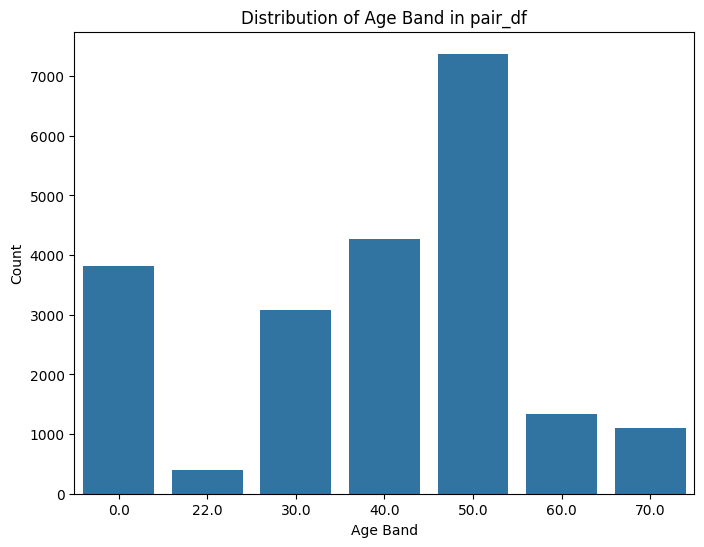

In [126]:
pair_df

household_key    BASKET_ID      PROMO_KEY  label              qid  \
0                 1  33192346254  54154888076|8      0    1_33192346254   
1                 1  33192346254  55100012140|8      0    1_33192346254   
2                 1  33192346254  10000085364|8      1    1_33192346254   
3                 1  33192346254  10000089020|8      0    1_33192346254   
4                 1  33192346254  10000085362|8      0    1_33192346254   
...             ...          ...            ...    ...              ...   
21371           998  33316255329  52740020076|8      1  998_33316255329   
21372           998  33316255329  51312010033|8      0  998_33316255329   
21373           998  33316255329  10000085364|8      0  998_33316255329   
21374           998  33316255329  10000089055|8      0  998_33316255329   
21375           998  33316255329  57045970076|8      0  998_33316255329   

       basket_total_value  basket_total_qty  basket_num_items  \
0                   85.95                41                33   
1                   85.95                41                33   
2                   85.95                41                33   
3                   85.95                41                33   
4                   85.95                41                33   
...                   ...               ...               ...   
21371               22.07                 9                 7   
21372               22.07                 9                 7   
21373               22.07                 9                 7   
21374               22.07                 9                 7   
21375               22.07                 9                 7   

       basket_avg_price                                    basket_products  \
0              2.096341  {852662, 13672182, 1050310, 931136, 1006546, 1...   
1              2.096341  {852662, 13672182, 1050310, 931136, 1006546, 1...   
2              2.096341  {852662, 13672182, 1050310, 931136, 1006546, 1...   
3              2.096341  {852662, 13672182, 1050310, 931136, 1006546, 1...   
4              2.096341  {852662, 13672182, 1050310, 931136, 1006546, 1...   
...                 ...                                                ...   
21371          2.452222  {1051283, 866223, 8090509, 8090537, 8090521, 9...   
21372          2.452222  {1051283, 866223, 8090509, 8090537, 8090521, 9...   
21373          2.452222  {1051283, 866223, 8090509, 8090537, 8090521, 9...   
21374          2.452222  {1051283, 866223, 8090509, 8090537, 8090521, 9...   
21375          2.452222  {1051283, 866223, 8090509, 8090537, 8090521, 9...   

       age_mid  user_age_norm  
0         70.0            1.0  
1         70.0            1.0  
2         70.0            1.0  
3         70.0            1.0  
4         70.0            1.0  
...        ...            ...  
21371      0.0            0.0  
21372      0.0            0.0  
21373      0.0            0.0  
21374      0.0            0.0  
21375      0.0            0.0  

[21376 rows x 12 columns]

In [127]:
orders_fast

household_key  day_t    BASKET_ID  \
0                  1     51  27601281299   
1                  1     67  27774192959   
2                  1     88  28024266849   
3                  1     94  28106322445   
4                  1    101  28235481967   
...              ...    ...          ...   
130759           998    683  41918011754   
130760           998    691  42031013564   
130761           998    693  42049756099   
130762           998    694  42063285897   
130763           998    703  42185598715   

                                                    items  \
0       {825123, 852014, 977545, 1043064, 1006546, 102...   
1       {6773032, 997025, 852662, 1055831, 9527290, 92...   
2       {1135096, 995242, 865178, 1075074, 9527290, 99...   
3       {5978656, 852662, 827656, 878285, 1024128, 857...   
4       {8181377, 852662, 5565840, 995242, 9527290, 93...   
...                                                   ...   
130759              {1134152, 1091365, 1007136, 15830211}   
130760           {981760, 995242, 899624, 849843, 845208}   
130761                                           {962568}   
130762                         {843338, 12524086, 865874}   
130763                        {1018085, 6533765, 1049922}   

                                           hist_exclusive  
0                                                      {}  
1       {1082185, 825123, 852014, 977545, 1043064, 940...  
2       {852662, 825123, 852014, 977545, 1043064, 9527...  
3       {852662, 825123, 852014, 977545, 1043064, 9527...  
4       {5978656, 852662, 825123, 852014, 977545, 1043...  
...                                                   ...  
130759  {1094466, 1031864, 901460, 1037840, 845208, 96...  
130760  {1094466, 1031864, 901460, 1037840, 845208, 96...  
130761  {1094466, 1031864, 901460, 1037840, 845208, 96...  
130762  {1094466, 1031864, 901460, 1037840, 845208, 96...  
130763  {1094466, 1031864, 901460, 1037840, 845208, 96...  

[130764 rows x 5 columns]

In [128]:
pair_df = pair_df.merge(
    orders_fast[['household_key', 'BASKET_ID','day_t']],
    on=['household_key', 'BASKET_ID'],
    how='left'
)

In [129]:
pair_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21376 entries, 0 to 21375
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   household_key       21376 non-null  object 
 1   BASKET_ID           21376 non-null  object 
 2   PROMO_KEY           21376 non-null  object 
 3   label               21376 non-null  int64  
 4   qid                 21376 non-null  object 
 5   basket_total_value  21376 non-null  float64
 6   basket_total_qty    21376 non-null  int64  
 7   basket_num_items    21376 non-null  int64  
 8   basket_avg_price    21376 non-null  float64
 9   basket_products     21376 non-null  object 
 10  age_mid             21376 non-null  float64
 11  user_age_norm       21376 non-null  float64
 12  day_t               21376 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 2.1+ MB


In [130]:
print(pair_df.columns.tolist())

['household_key', 'BASKET_ID', 'PROMO_KEY', 'label', 'qid', 'basket_total_value', 'basket_total_qty', 'basket_num_items', 'basket_avg_price', 'basket_products', 'age_mid', 'user_age_norm', 'day_t']


In [131]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CELL: User-Promo Match Features (OPTIMIZED)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import time

print("="*70)
print("🎯 Building User-Promo Match Features (OPTIMIZED)")
print("="*70)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 1: Pre-compute Transaction Lookups
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n📊 Pre-computing transaction lookups...")
start = time.time()

# สร้าง lookup dict: (household, product) → list of transactions
tx_sorted = transaction_data.sort_values(['household_key', 'PRODUCT_ID', 'DAY'])

hh_pid_history = defaultdict(list)

for row in tx_sorted.itertuples(index=False):
    key = (row.household_key, row.PRODUCT_ID)
    hh_pid_history[key].append({
        'day': int(row.DAY),
        'qty': float(row.QUANTITY),
        'value': float(row.SALES_VALUE)
    })

print(f"   ✅ Built lookup: {len(hh_pid_history):,} entries in {time.time() - start:.1f}s")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 2: Calculate Features (Vectorized)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n🚀 Calculating features...")
start = time.time()

n = len(pair_df)

# Initialize arrays
match_overlap_cnt = np.zeros(n, dtype=np.int32)
match_overlap_ratio = np.zeros(n, dtype=np.float32)
match_recency_min = np.full(n, -1, dtype=np.int32)
match_recency_avg = np.full(n, -1.0, dtype=np.float32)
match_freq_30d = np.zeros(n, dtype=np.int32)
match_avg_qty = np.zeros(n, dtype=np.float32)
match_avg_price = np.zeros(n, dtype=np.float32)

# Loop with progress
for i, row in enumerate(pair_df.itertuples(index=False)):
    if i % 5000 == 0:
        elapsed = time.time() - start
        if i > 0:
            eta = elapsed / i * (n - i)
            print(f"   Progress: {i:,}/{n:,} ({i/n*100:.1f}%) - ETA: {eta:.0f}s")

    hh = row.household_key
    day_t = int(row.day_t)
    promo_key = row.PROMO_KEY

    # สินค้าในโปรโมชัน
    promo_prods = promo_to_products.get(promo_key, set())
    if not promo_prods:
        continue

    # เก็บข้อมูล
    bought_prods = []
    all_recencies = []
    freq_count = 0
    total_qty = 0
    total_value = 0
    total_txns = 0

    for pid in promo_prods:
        history = hh_pid_history.get((hh, pid))
        if not history:
            continue

        # Filter ก่อน day_t (ป้องกัน leakage!)
        valid_txns = [tx for tx in history if tx['day'] < day_t]
        if not valid_txns:
            continue

        bought_prods.append(pid)

        # Recency
        last_day = max(tx['day'] for tx in valid_txns)
        recency = day_t - last_day
        all_recencies.append(recency)

        # Frequency (30 days)
        recent = [tx for tx in valid_txns if tx['day'] > day_t - 31]
        freq_count += len(recent)

        # Qty & Value
        for tx in valid_txns:
            total_qty += tx['qty']
            total_value += tx['value']
            total_txns += 1

    # บันทึก
    if bought_prods:
        match_overlap_cnt[i] = len(bought_prods)
        match_overlap_ratio[i] = len(bought_prods) / len(promo_prods)
        match_recency_min[i] = min(all_recencies)
        match_recency_avg[i] = np.mean(all_recencies)
        match_freq_30d[i] = freq_count
        match_avg_qty[i] = total_qty / total_txns
        match_avg_price[i] = total_value / total_qty if total_qty > 0 else 0

print(f"\n   ✅ Calculated in {time.time() - start:.1f}s")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 3: Add to DataFrame & Transform
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

pair_df['match_overlap_cnt'] = match_overlap_cnt + 10      # shift +10
pair_df['match_overlap_ratio'] = match_overlap_ratio
pair_df['match_recency_min'] = match_recency_min
pair_df['match_recency_avg'] = match_recency_avg
pair_df['match_freq_30d'] = match_freq_30d + 10            # shift +10
pair_df['match_avg_qty'] = match_avg_qty + 10              # shift +10
pair_df['match_avg_price'] = match_avg_price

print("\n" + "="*70)
print("✅ SUCCESS! Added 7 User-Promo Match features")
print("="*70)

print(f"\nStatistics:")
print(f"  Pairs with match:   {(pair_df['match_overlap_cnt'] > 10).sum():,} / {len(pair_df):,} ({(pair_df['match_overlap_cnt'] > 10).mean()*100:.1f}%)")
print(f"  Avg overlap:        {pair_df['match_overlap_cnt'].mean():.2f}")
print(f"  Avg overlap ratio:  {pair_df['match_overlap_ratio'].mean():.3f}")

has_rec = pair_df['match_recency_min'] > 0
if has_rec.any():
    print(f"  Avg recency:        {pair_df.loc[has_rec, 'match_recency_min'].mean():.1f} days")

print(f"  Avg freq (30d):     {pair_df['match_freq_30d'].mean():.2f}")
print(f"  Avg qty:            {pair_df['match_avg_qty'].mean():.2f}")
print(f"  Avg price:          ${pair_df['match_avg_price'].mean():.2f}")

print("\n" + "="*70)

🎯 Building User-Promo Match Features (OPTIMIZED)

📊 Pre-computing transaction lookups...
   ✅ Built lookup: 844,158 entries in 30.0s

🚀 Calculating features...
   Progress: 5,000/21,376 (23.4%) - ETA: 10s
   Progress: 10,000/21,376 (46.8%) - ETA: 7s
   Progress: 15,000/21,376 (70.2%) - ETA: 4s
   Progress: 20,000/21,376 (93.6%) - ETA: 1s

   ✅ Calculated in 12.8s

✅ SUCCESS! Added 7 User-Promo Match features

Statistics:
  Pairs with match:   17,444 / 21,376 (81.6%)
  Avg overlap:        24.76
  Avg overlap ratio:  0.062
  Avg recency:        102.7 days
  Avg freq (30d):     12.24
  Avg qty:            10.99
  Avg price:          $2.14



In [132]:
pair_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21376 entries, 0 to 21375
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   household_key        21376 non-null  object 
 1   BASKET_ID            21376 non-null  object 
 2   PROMO_KEY            21376 non-null  object 
 3   label                21376 non-null  int64  
 4   qid                  21376 non-null  object 
 5   basket_total_value   21376 non-null  float64
 6   basket_total_qty     21376 non-null  int64  
 7   basket_num_items     21376 non-null  int64  
 8   basket_avg_price     21376 non-null  float64
 9   basket_products      21376 non-null  object 
 10  age_mid              21376 non-null  float64
 11  user_age_norm        21376 non-null  float64
 12  day_t                21376 non-null  int64  
 13  match_overlap_cnt    21376 non-null  int32  
 14  match_overlap_ratio  21376 non-null  float32
 15  match_recency_min    21376 non-null 

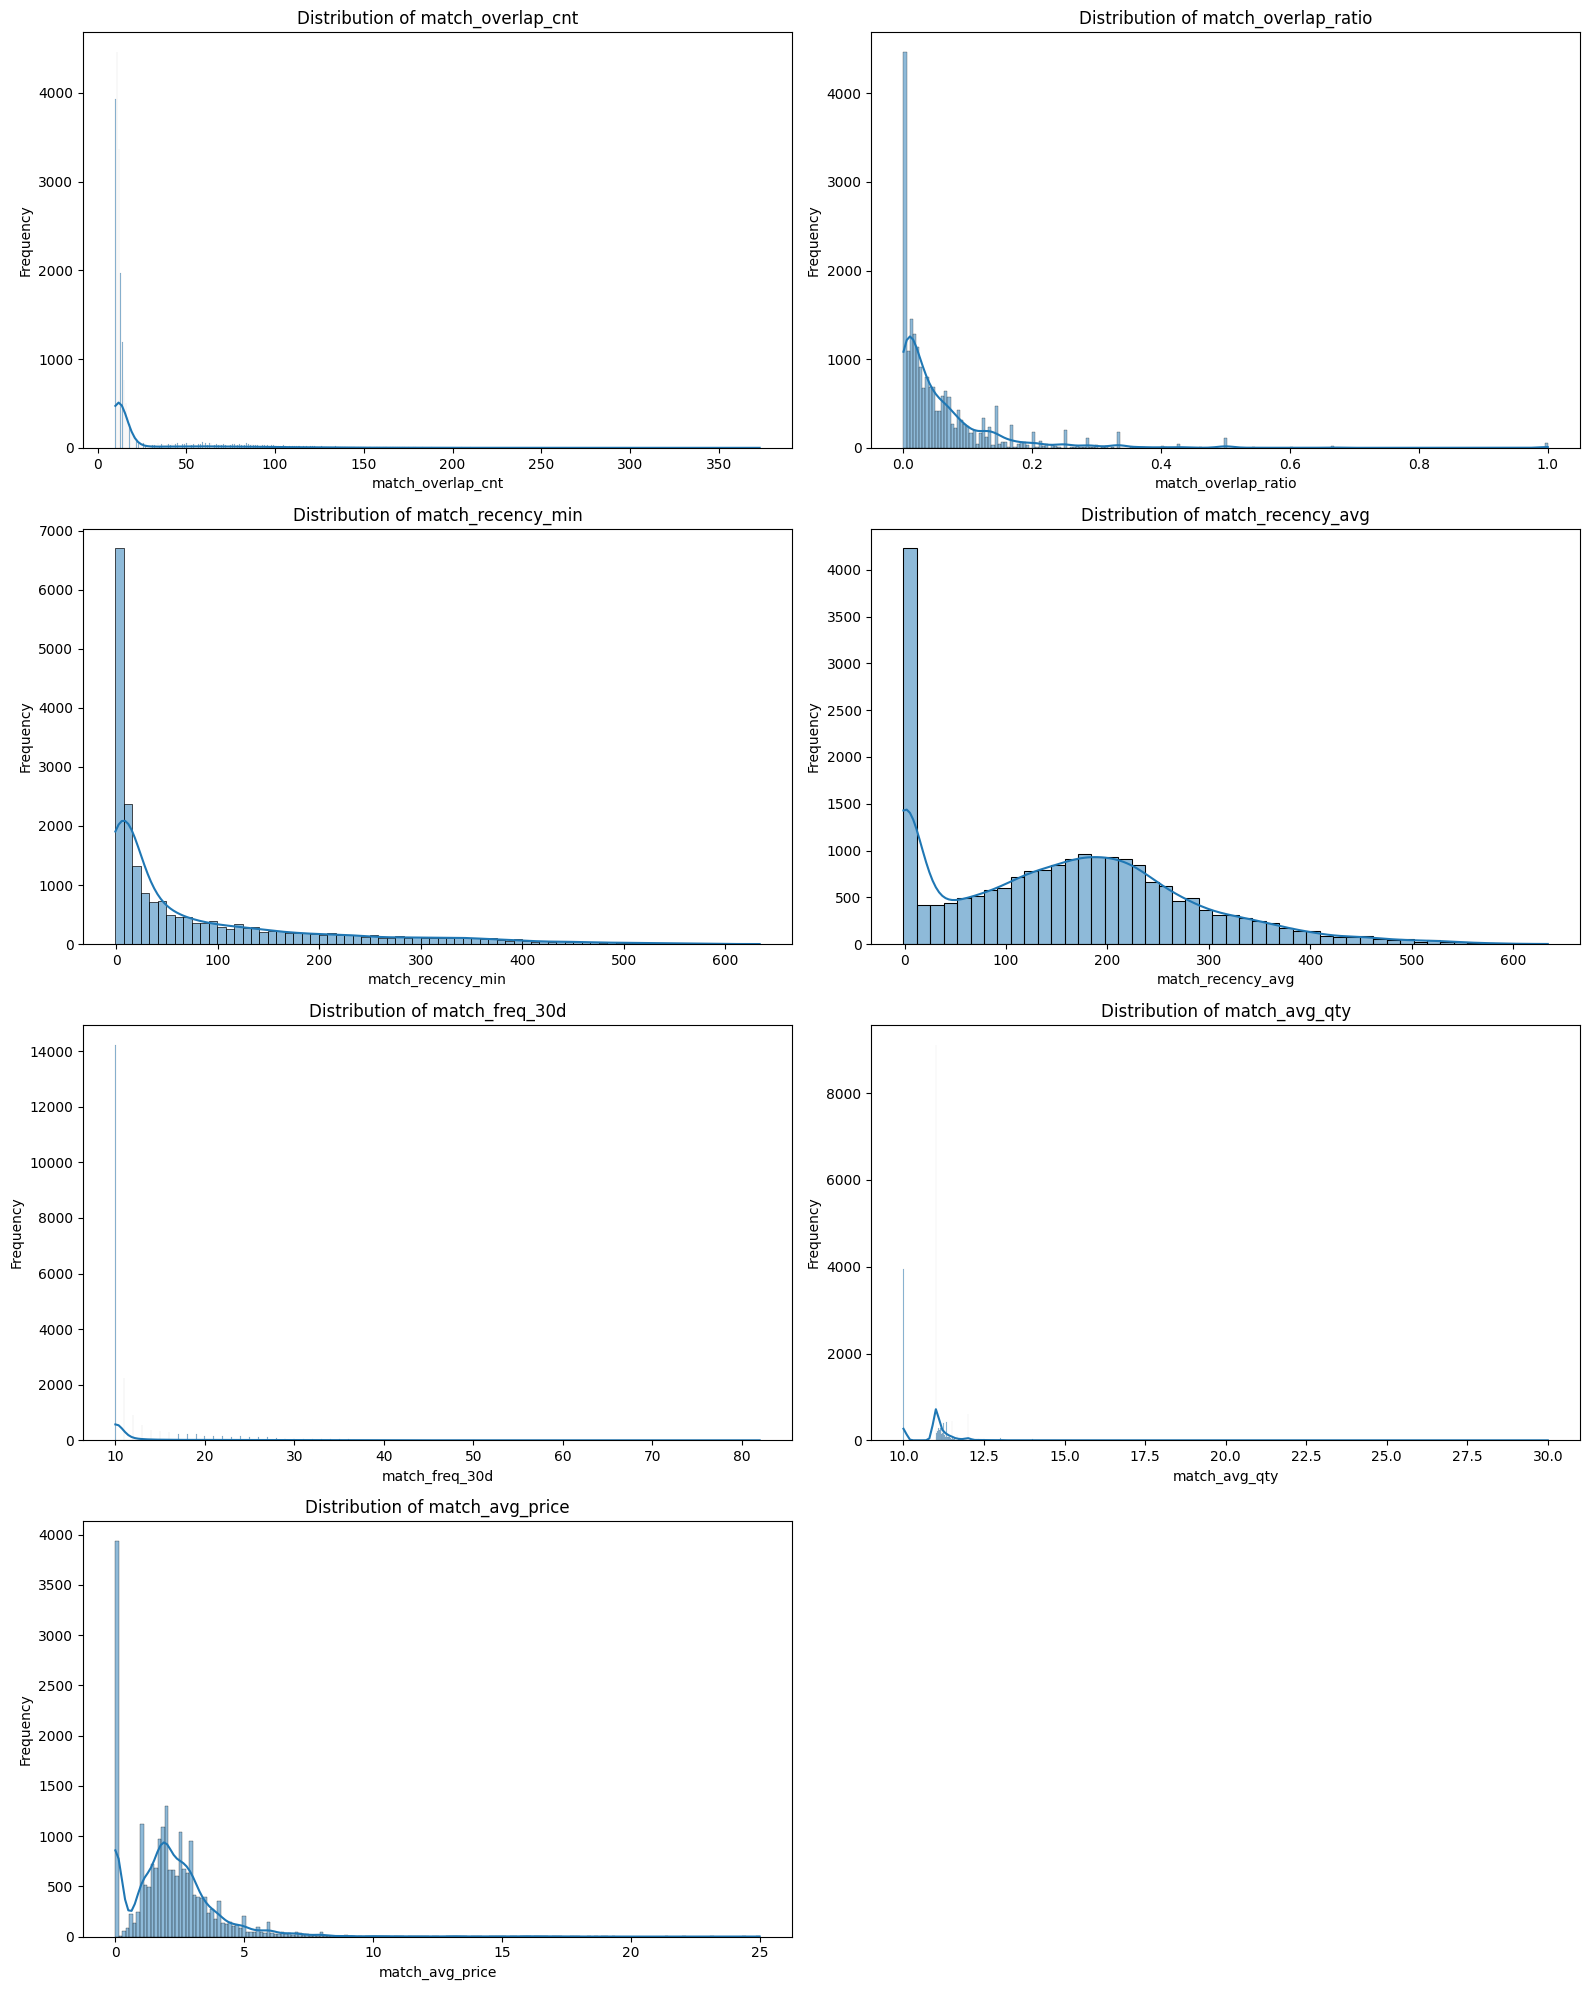

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

match_features = [
    'match_overlap_cnt',
    'match_overlap_ratio',
    'match_recency_min',
    'match_recency_avg',
    'match_freq_30d',
    'match_avg_qty',
    'match_avg_price'
]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))
axes = axes.flatten()

for i, col in enumerate(match_features):
    sns.histplot(data=pair_df, x=col, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove the unused subplot
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [136]:
pair_df.drop('match_freq_30d', axis=1, inplace=True)

In [138]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CELL: Promo-Basket Match (FAST VERSION)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import time

print("="*70)
print("🛒 Promo-Basket Match (FAST)")
print("="*70)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 1: Pre-compute Basket Product Details (รันครั้งเดียว!)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n📊 Pre-computing basket details...")
start = time.time()

# Dict: (household, basket, product) → (value, qty)
basket_product_details = {}

for row in transaction_data.itertuples(index=False):
    key = (row.household_key, row.BASKET_ID, row.PRODUCT_ID)
    basket_product_details[key] = {
        'value': float(row.SALES_VALUE),
        'qty': float(row.QUANTITY)
    }

print(f"   ✅ Built lookup: {len(basket_product_details):,} entries in {time.time() - start:.1f}s")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 2: Calculate Features (Fast Loop)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n🚀 Calculating features...")
start = time.time()

n = len(pair_df)

# Initialize arrays
basket_overlap_cnt = np.zeros(n, dtype=np.int32)
basket_overlap_ratio = np.zeros(n, dtype=np.float32)
basket_overlap_value = np.zeros(n, dtype=np.float32)
basket_overlap_qty = np.zeros(n, dtype=np.float32)

# Get arrays for fast access
hh_arr = pair_df['household_key'].values
bid_arr = pair_df['BASKET_ID'].values
promo_arr = pair_df['PROMO_KEY'].values
basket_prods_arr = pair_df['basket_products'].values

# Loop
for i in range(n):
    if i % 5000 == 0 and i > 0:
        elapsed = time.time() - start
        eta = elapsed / i * (n - i)
        print(f"   Progress: {i:,}/{n:,} ({i/n*100:.1f}%) - ETA: {eta:.0f}s")

    hh = hh_arr[i]
    bid = bid_arr[i]
    promo_key = promo_arr[i]
    basket_prods = basket_prods_arr[i]

    # Convert to set
    if not isinstance(basket_prods, set):
        basket_prods = set()

    # สินค้าในโปรโมชัน
    promo_prods = promo_to_products.get(promo_key, set())

    if not basket_prods or not promo_prods:
        continue

    # หาสินค้าที่ตรงกัน
    overlap = basket_prods & promo_prods

    if not overlap:
        continue

    # หามูลค่าและจำนวน (ใช้ dict lookup แทน DataFrame filter!)
    total_value = 0.0
    total_qty = 0.0

    for pid in overlap:
        key = (hh, bid, pid)
        details = basket_product_details.get(key)
        if details:
            total_value += details['value']
            total_qty += details['qty']

    # บันทึก
    basket_overlap_cnt[i] = len(overlap)
    basket_overlap_ratio[i] = len(overlap) / len(promo_prods)
    basket_overlap_value[i] = total_value
    basket_overlap_qty[i] = total_qty

print(f"\n   ✅ Done in {time.time() - start:.1f}s")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# STEP 3: Add to DataFrame
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

pair_df['basket_overlap_cnt'] = basket_overlap_cnt + 10       # shift +10
pair_df['basket_overlap_ratio'] = basket_overlap_ratio
pair_df['basket_overlap_value'] = basket_overlap_value
pair_df['basket_overlap_qty'] = basket_overlap_qty + 10       # shift +10

print("\n" + "="*70)
print("✅ SUCCESS! Added 4 Promo-Basket Match features")
print("="*70)

print(f"\n📊 Statistics:")
print(f"   Baskets with match: {(pair_df['basket_overlap_cnt'] > 10).sum():,} / {len(pair_df):,} ({(pair_df['basket_overlap_cnt'] > 10).mean()*100:.1f}%)")
print(f"   Avg overlap count:  {pair_df['basket_overlap_cnt'].mean():.2f}")
print(f"   Avg overlap ratio:  {pair_df['basket_overlap_ratio'].mean():.3f}")
print(f"   Avg overlap value:  ${pair_df['basket_overlap_value'].mean():.2f}")
print(f"   Avg overlap qty:    {pair_df['basket_overlap_qty'].mean():.2f}")

print("\n" + "="*70)

🛒 Promo-Basket Match (FAST)

📊 Pre-computing basket details...
   ✅ Built lookup: 1,751,648 entries in 26.1s

🚀 Calculating features...
   Progress: 5,000/21,376 (23.4%) - ETA: 0s
   Progress: 10,000/21,376 (46.8%) - ETA: 0s
   Progress: 15,000/21,376 (70.2%) - ETA: 0s
   Progress: 20,000/21,376 (93.6%) - ETA: 0s

   ✅ Done in 0.1s

✅ SUCCESS! Added 4 Promo-Basket Match features

📊 Statistics:
   Baskets with match: 4,784 / 21,376 (22.4%)
   Avg overlap count:  10.64
   Avg overlap ratio:  0.006
   Avg overlap value:  $1.96
   Avg overlap qty:    10.83



In [139]:
pair_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21376 entries, 0 to 21375
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   household_key         21376 non-null  object 
 1   BASKET_ID             21376 non-null  object 
 2   PROMO_KEY             21376 non-null  object 
 3   label                 21376 non-null  int64  
 4   qid                   21376 non-null  object 
 5   basket_total_value    21376 non-null  float64
 6   basket_total_qty      21376 non-null  int64  
 7   basket_num_items      21376 non-null  int64  
 8   basket_avg_price      21376 non-null  float64
 9   basket_products       21376 non-null  object 
 10  age_mid               21376 non-null  float64
 11  user_age_norm         21376 non-null  float64
 12  day_t                 21376 non-null  int64  
 13  match_overlap_cnt     21376 non-null  int32  
 14  match_overlap_ratio   21376 non-null  float32
 15  match_recency_min  

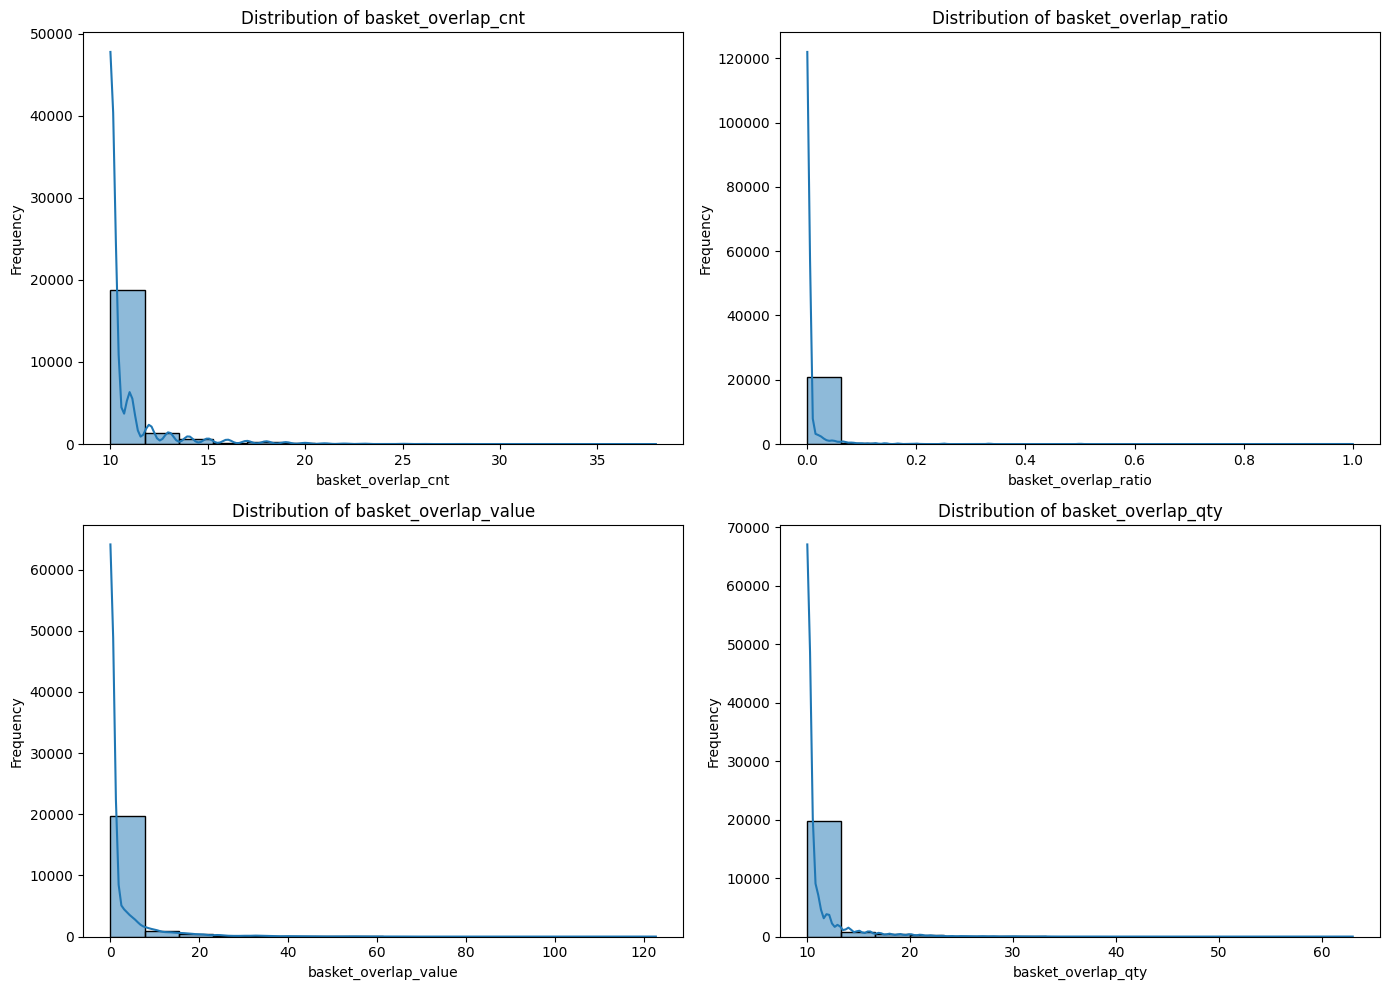

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

basket_overlap_features = [
    'basket_overlap_cnt',
    'basket_overlap_ratio',
    'basket_overlap_value',
    'basket_overlap_qty'
]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(basket_overlap_features):
    sns.histplot(data=pair_df, x=col, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [155]:
pair_df['basket_overlap_ratio'].describe()

count    21376.000000
mean         0.005529
std          0.028735
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: basket_overlap_ratio, dtype: float64

In [145]:
pair_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21376 entries, 0 to 21375
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   household_key         21376 non-null  object 
 1   BASKET_ID             21376 non-null  object 
 2   PROMO_KEY             21376 non-null  object 
 3   label                 21376 non-null  int64  
 4   qid                   21376 non-null  object 
 5   basket_total_value    21376 non-null  float64
 6   basket_total_qty      21376 non-null  int64  
 7   basket_num_items      21376 non-null  int64  
 8   basket_avg_price      21376 non-null  float64
 9   basket_products       21376 non-null  object 
 10  age_mid               21376 non-null  float64
 11  user_age_norm         21376 non-null  float64
 12  day_t                 21376 non-null  int64  
 13  match_overlap_cnt     21376 non-null  int32  
 14  match_overlap_ratio   21376 non-null  float32
 15  match_recency_min  

In [156]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CELL: Promo Properties (Super Fast!)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("="*70)
print("📦 Promo Properties")
print("="*70)

# 1) Number of products in promo
pair_df['promo_num_products'] = pair_df['PROMO_KEY'].map(
    lambda pk: len(promo_to_products.get(pk, set()))
)

# 2) Merge promo_stats (มีอยู่แล้ว!)
pair_df = pair_df.merge(
    promo_stats.reset_index(),
    on='PROMO_KEY',
    how='left'
)

# Fill NaN
pair_df['feat_num_depts'] = pair_df['feat_num_depts'].fillna(1)
pair_df['feat_num_brands'] = pair_df['feat_num_brands'].fillna(1)
pair_df['feat_num_products'] = pair_df['feat_num_products'].fillna(1)

print(f"\n✅ Added 4 features (instant!)")
print(f"   promo_num_products:  mean={pair_df['promo_num_products'].mean():.1f}")
print(f"   feat_num_depts:      mean={pair_df['feat_num_depts'].mean():.1f}")
print(f"   feat_num_brands:     mean={pair_df['feat_num_brands'].mean():.1f}")
print(f"   feat_num_products:   mean={pair_df['feat_num_products'].mean():.1f}")

print("="*70)

📦 Promo Properties

✅ Added 4 features (instant!)
   promo_num_products:  mean=1112.6
   feat_num_depts:      mean=3.7
   feat_num_brands:     mean=2.1
   feat_num_products:   mean=1114.0


In [157]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CELL: User Loyalty & Promo Timing (Simple & Useful!)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import time

print("="*70)
print("🎯 User Loyalty & Promo Timing")
print("="*70)

start = time.time()

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 1) User Loyalty: จำนวนวันที่ซื้อใน 30 วันล่าสุด
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Pre-compute: user → {day: True}
user_active_days = defaultdict(set)

for row in transaction_data.itertuples(index=False):
    user_active_days[row.household_key].add(int(row.DAY))

# Calculate for each pair
user_loyalty = []

for hh, day_t in pair_df[['household_key', 'day_t']].values:
    active_days = user_active_days.get(hh, set())

    # นับจำนวนวันที่ซื้อใน 30 วันก่อนหน้า
    recent_days = [d for d in active_days if day_t - 30 <= d < day_t]
    user_loyalty.append(len(recent_days))

pair_df['user_active_days_30d'] = user_loyalty

print(f"   user_active_days_30d: mean={np.mean(user_loyalty):.1f} days")

print("="*70)

🎯 User Loyalty & Promo Timing
   user_active_days_30d: mean=8.4 days
   promo_days_left:      mean=26.9 days
   promo_is_urgent:      11.7% urgent

✅ Added 3 features in 16.9s


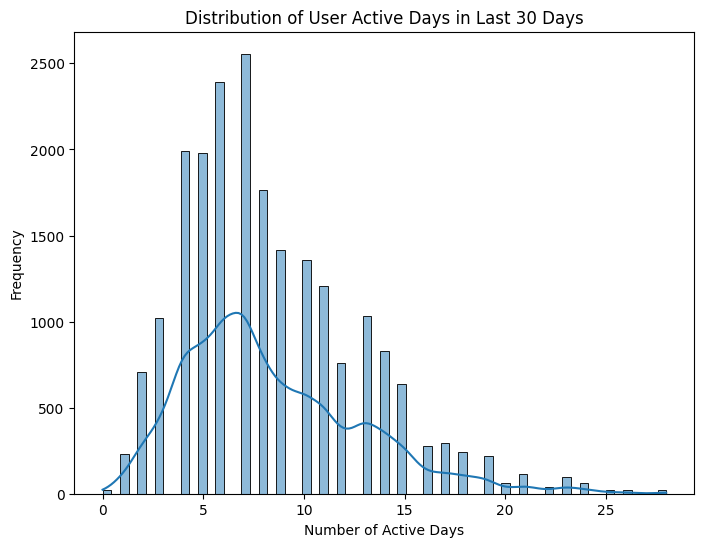

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.histplot(data=pair_df, x='user_active_days_30d', kde=True)
plt.title('Distribution of User Active Days in Last 30 Days')
plt.xlabel('Number of Active Days')
plt.ylabel('Frequency')
plt.show()

In [158]:
pair_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21376 entries, 0 to 21375
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   household_key         21376 non-null  object 
 1   BASKET_ID             21376 non-null  object 
 2   PROMO_KEY             21376 non-null  object 
 3   label                 21376 non-null  int64  
 4   qid                   21376 non-null  object 
 5   basket_total_value    21376 non-null  float64
 6   basket_total_qty      21376 non-null  int64  
 7   basket_num_items      21376 non-null  int64  
 8   basket_avg_price      21376 non-null  float64
 9   basket_products       21376 non-null  object 
 10  age_mid               21376 non-null  float64
 11  user_age_norm         21376 non-null  float64
 12  day_t                 21376 non-null  int64  
 13  match_overlap_cnt     21376 non-null  int32  
 14  match_overlap_ratio   21376 non-null  float32
 15  match_recency_min  

In [160]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CELL: Comprehensive Data Validation & Visualization
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("📊 PAIR_DF VALIDATION & VISUALIZATION")
print("="*80)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 1. BASIC INFO
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n📋 1. BASIC INFORMATION")
print("-"*80)
print(f"Shape: {pair_df.shape}")
print(f"Memory: {pair_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"\nColumns: {len(pair_df.columns)}")
print(f"  - Keys: {['household_key', 'BASKET_ID', 'PROMO_KEY', 'qid']}")
print(f"  - Label: ['label']")
print(f"  - Features: {pair_df.shape[1] - 6} (excluding keys + label + basket_products)")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 2. DATA QUALITY CHECK
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n🔍 2. DATA QUALITY CHECK")
print("-"*80)

# NaN check
nan_cols = pair_df.isnull().sum()
nan_cols = nan_cols[nan_cols > 0]
if len(nan_cols) > 0:
    print("⚠️  Found NaN values:")
    for col, count in nan_cols.items():
        print(f"   {col}: {count} ({count/len(pair_df)*100:.2f}%)")
else:
    print("✅ No NaN values")

# Inf check
numeric_cols = pair_df.select_dtypes(include=[np.number]).columns
inf_found = False
for col in numeric_cols:
    inf_count = np.isinf(pair_df[col]).sum()
    if inf_count > 0:
        print(f"⚠️  {col}: {inf_count} Inf values")
        inf_found = True
if not inf_found:
    print("✅ No Inf values")

# Duplicate check
dup_count = pair_df.duplicated(subset=['household_key', 'BASKET_ID', 'PROMO_KEY']).sum()
print(f"\nDuplicates: {dup_count}")
if dup_count > 0:
    print("⚠️  Found duplicates!")
else:
    print("✅ No duplicates")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 3. LABEL DISTRIBUTION
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n📊 3. LABEL DISTRIBUTION")
print("-"*80)

label_counts = pair_df['label'].value_counts()
print(f"Label 0 (negative): {label_counts.get(0, 0):,} ({label_counts.get(0, 0)/len(pair_df)*100:.2f}%)")
print(f"Label 1 (positive): {label_counts.get(1, 0):,} ({label_counts.get(1, 0)/len(pair_df)*100:.2f}%)")
print(f"Positive rate: {pair_df['label'].mean()*100:.2f}%")

if pair_df['label'].mean() < 0.05:
    print("⚠️  WARNING: Very low positive rate (<5%)")
elif pair_df['label'].mean() > 0.20:
    print("✅ Good positive rate (5-20%)")
else:
    print("✅ Acceptable positive rate")

# Query stats
query_sizes = pair_df.groupby('qid').size()
queries_with_pos = pair_df.groupby('qid')['label'].sum()

print(f"\nQuery statistics:")
print(f"  Total queries: {pair_df['qid'].nunique():,}")
print(f"  Queries with positive: {(queries_with_pos > 0).sum():,} ({(queries_with_pos > 0).mean()*100:.1f}%)")
print(f"  Avg candidates per query: {query_sizes.mean():.1f}")
print(f"  Min/Max candidates: {query_sizes.min()}/{query_sizes.max()}")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# 4. FEATURE GROUPS SUMMARY
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("\n📦 4. FEATURE GROUPS")
print("-"*80)

feature_groups = {
    'Basket': ['basket_total_value', 'basket_total_qty', 'basket_num_items', 'basket_avg_price'],
    'Demographics': ['age_mid', 'user_age_norm'],
    'User-Promo Match': ['match_overlap_cnt', 'match_overlap_ratio', 'match_recency_min',
                         'match_recency_avg', 'match_avg_qty', 'match_avg_price'],
    'Promo-Basket Match': ['basket_overlap_cnt', 'basket_overlap_ratio',
                           'basket_overlap_value', 'basket_overlap_qty'],
    'Binary Flags': ['has_basket_overlap', 'has_high_overlap', 'has_value_overlap'],
    'Promo Properties': ['promo_num_products', 'feat_num_depts', 'feat_num_brands', 'feat_num_products'],
    'Loyalty & Timing': ['user_active_days_30d', 'promo_days_left', 'promo_is_urgent']
}

for group_name, features in feature_groups.items():
    exists = [f for f in features if f in pair_df.columns]
    print(f"{group_name}: {len(exists)}/{len(features)} features")
    if len(exists) < len(features):
        missing = set(features) - set(exists)
        print(f"  ⚠️  Missing: {missing}")

print("\n" + "="*80)

📊 PAIR_DF VALIDATION & VISUALIZATION

📋 1. BASIC INFORMATION
--------------------------------------------------------------------------------
Shape: (21376, 33)
Memory: 48.62 MB

Columns: 33
  - Keys: ['household_key', 'BASKET_ID', 'PROMO_KEY', 'qid']
  - Label: ['label']
  - Features: 27 (excluding keys + label + basket_products)

🔍 2. DATA QUALITY CHECK
--------------------------------------------------------------------------------
✅ No NaN values
✅ No Inf values

Duplicates: 0
✅ No duplicates

📊 3. LABEL DISTRIBUTION
--------------------------------------------------------------------------------
Label 0 (negative): 19,303 (90.30%)
Label 1 (positive): 2,073 (9.70%)
Positive rate: 9.70%
✅ Acceptable positive rate

Query statistics:
  Total queries: 1,094
  Queries with positive: 1,094 (100.0%)
  Avg candidates per query: 19.5
  Min/Max candidates: 2/20

📦 4. FEATURE GROUPS
--------------------------------------------------------------------------------
Basket: 4/4 features
Demograph

📊 FEATURE DISTRIBUTIONS

Plotting 26 features...


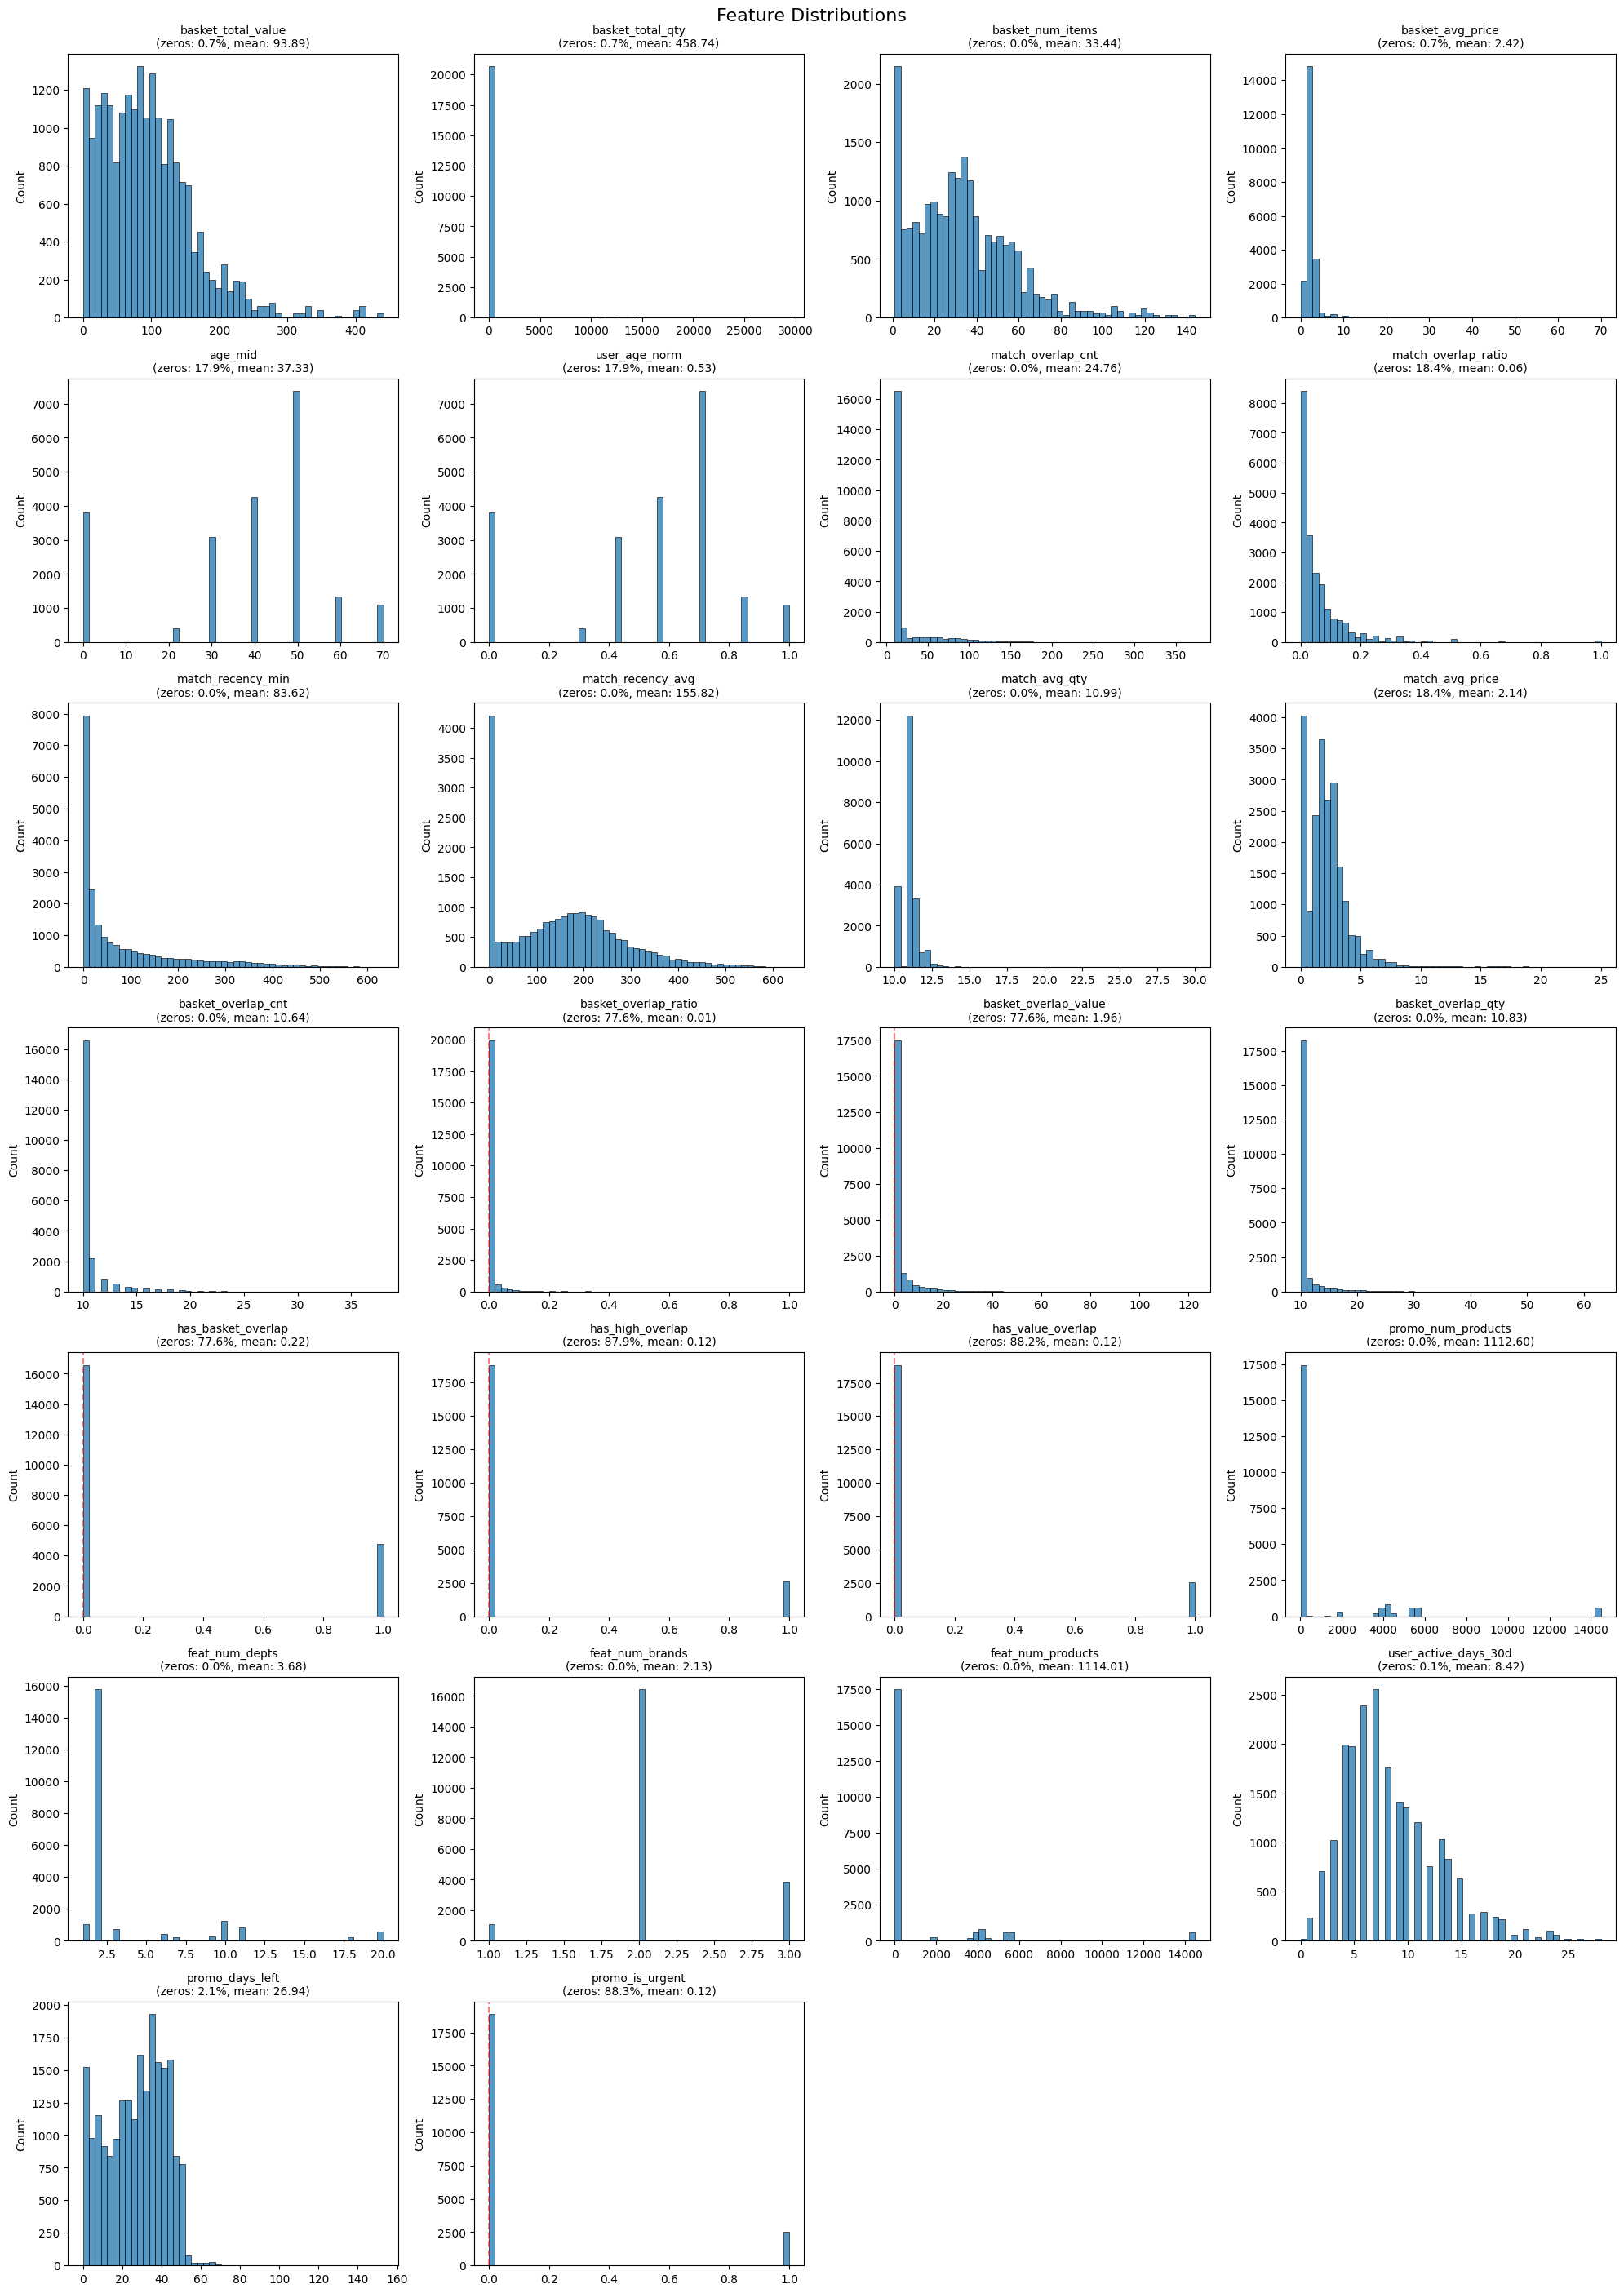

✅ Plotted 26 features


In [161]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CELL: Distribution Plots
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("="*80)
print("📊 FEATURE DISTRIBUTIONS")
print("="*80)

# Select numeric features for model
model_features = []
for features in feature_groups.values():
    model_features.extend([f for f in features if f in pair_df.columns])

# Remove non-numeric
model_features = [f for f in model_features if f in pair_df.select_dtypes(include=[np.number]).columns]

print(f"\nPlotting {len(model_features)} features...")

# Plot distributions (4x7 grid)
n_features = len(model_features)
n_cols = 4
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows*4))
axes = axes.flatten() if n_rows > 1 else [axes]

for i, col in enumerate(model_features):
    ax = axes[i]

    # Calculate stats
    data = pair_df[col]
    zero_pct = (data == 0).mean() * 100

    # Plot
    sns.histplot(data=pair_df, x=col, ax=ax, kde=False, bins=50)

    # Add stats
    ax.set_title(f'{col}\n(zeros: {zero_pct:.1f}%, mean: {data.mean():.2f})', fontsize=10)
    ax.set_xlabel('')

    # Add zero line if significant
    if zero_pct > 30:
        ax.axvline(0, color='red', linestyle='--', alpha=0.5)

# Remove empty subplots
for i in range(n_features, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Feature Distributions', fontsize=16, y=1.002)
plt.show()

print(f"✅ Plotted {n_features} features")

📈 CREATING FEATURE LINE PLOT
Plotting 26 features...


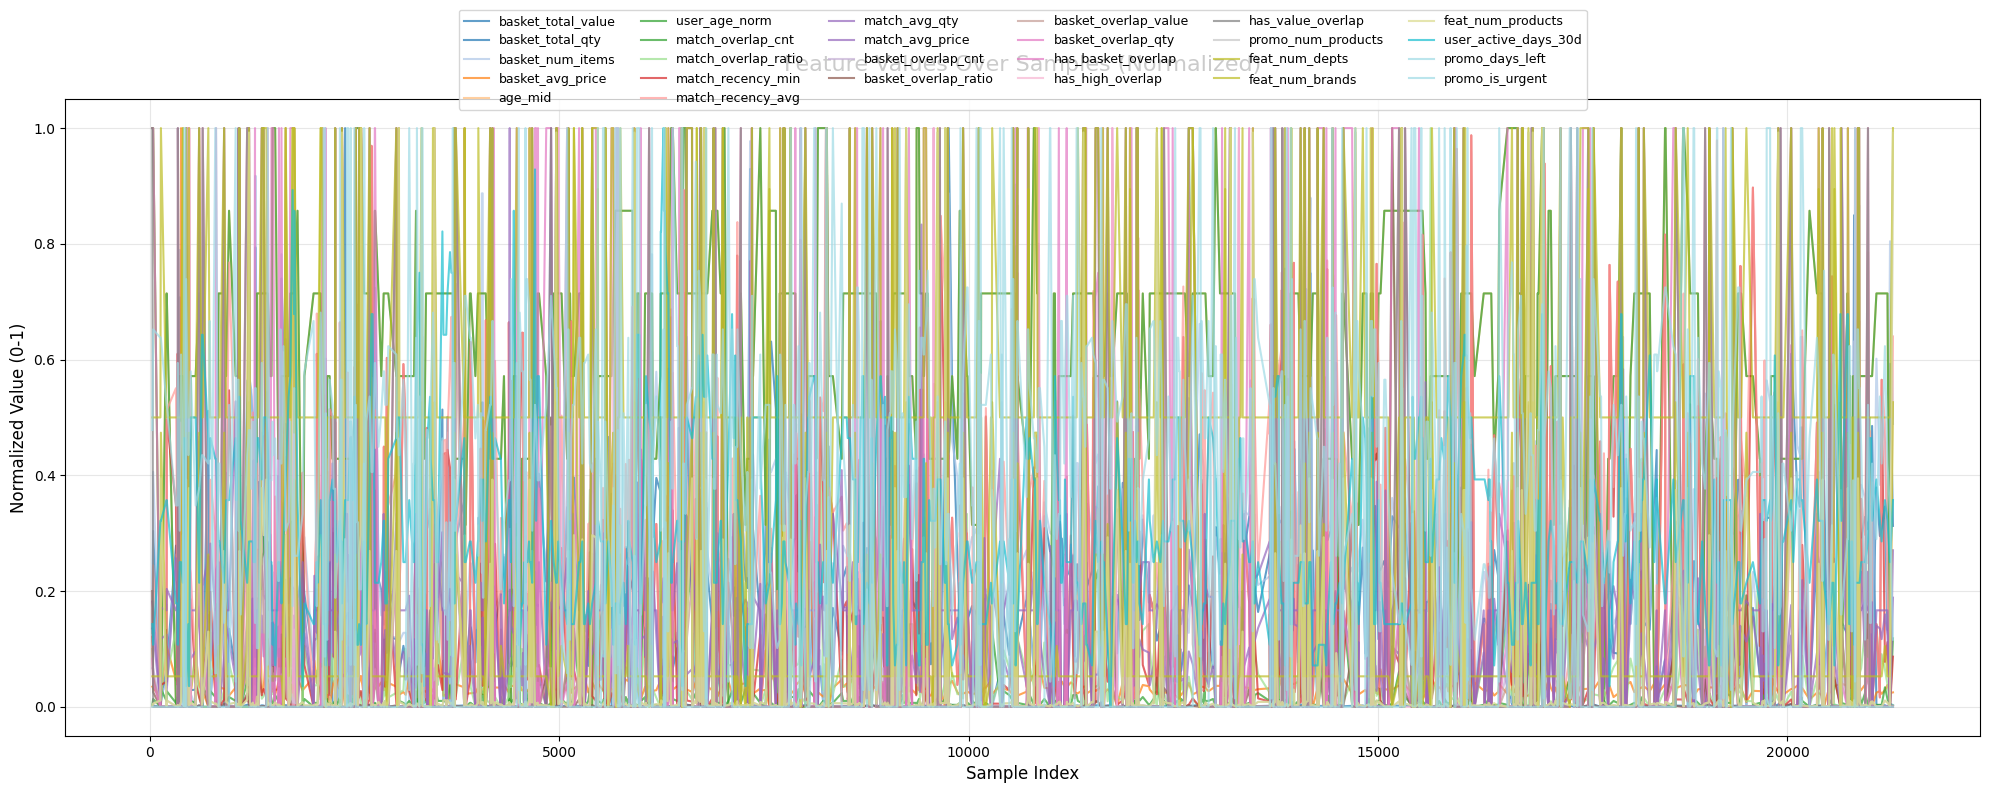

✅ Plotted 26 features
   Sample size: 1000 rows


In [162]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CELL: Feature Line Plot (Like Your Image)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("📈 CREATING FEATURE LINE PLOT")
print("="*80)

# Define model features (exclude keys and label)
model_features = [
    # Basket
    'basket_total_value', 'basket_total_qty', 'basket_num_items', 'basket_avg_price',

    # Demographics
    'age_mid', 'user_age_norm',

    # User-Promo Match
    'match_overlap_cnt', 'match_overlap_ratio', 'match_recency_min',
    'match_recency_avg', 'match_avg_qty', 'match_avg_price',

    # Promo-Basket Match
    'basket_overlap_cnt', 'basket_overlap_ratio',
    'basket_overlap_value', 'basket_overlap_qty',

    # Binary Flags
    'has_basket_overlap', 'has_high_overlap', 'has_value_overlap',

    # Promo Properties
    'promo_num_products', 'feat_num_depts', 'feat_num_brands', 'feat_num_products',

    # Loyalty & Timing
    'user_active_days_30d', 'promo_days_left', 'promo_is_urgent'
]

# Filter features that exist
model_features = [f for f in model_features if f in pair_df.columns]

print(f"Plotting {len(model_features)} features...")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Normalize features (0-1 scale) สำหรับ visualization
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

from sklearn.preprocessing import MinMaxScaler

# สุ่มตัวอย่าง (ถ้าข้อมูลเยอะเกินไป)
sample_size = min(1000, len(pair_df))
df_sample = pair_df.sample(n=sample_size, random_state=42).sort_index()

# Normalize
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(
    scaler.fit_transform(df_sample[model_features]),
    columns=model_features,
    index=df_sample.index
)

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Plot
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

plt.figure(figsize=(20, 8))

# Generate colors
colors = plt.cm.tab20(np.linspace(0, 1, len(model_features)))

# Plot each feature
for i, col in enumerate(model_features):
    plt.plot(df_normalized.index, df_normalized[col],
             label=col, alpha=0.7, linewidth=1.5, color=colors[i])

# Styling
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Normalized Value (0-1)', fontsize=12)
plt.title('Feature Values Over Samples (Normalized)', fontsize=16, pad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
           ncol=6, fontsize=9, frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

print(f"✅ Plotted {len(model_features)} features")
print(f"   Sample size: {sample_size} rows")

📈 GROUPED FEATURE PLOTS


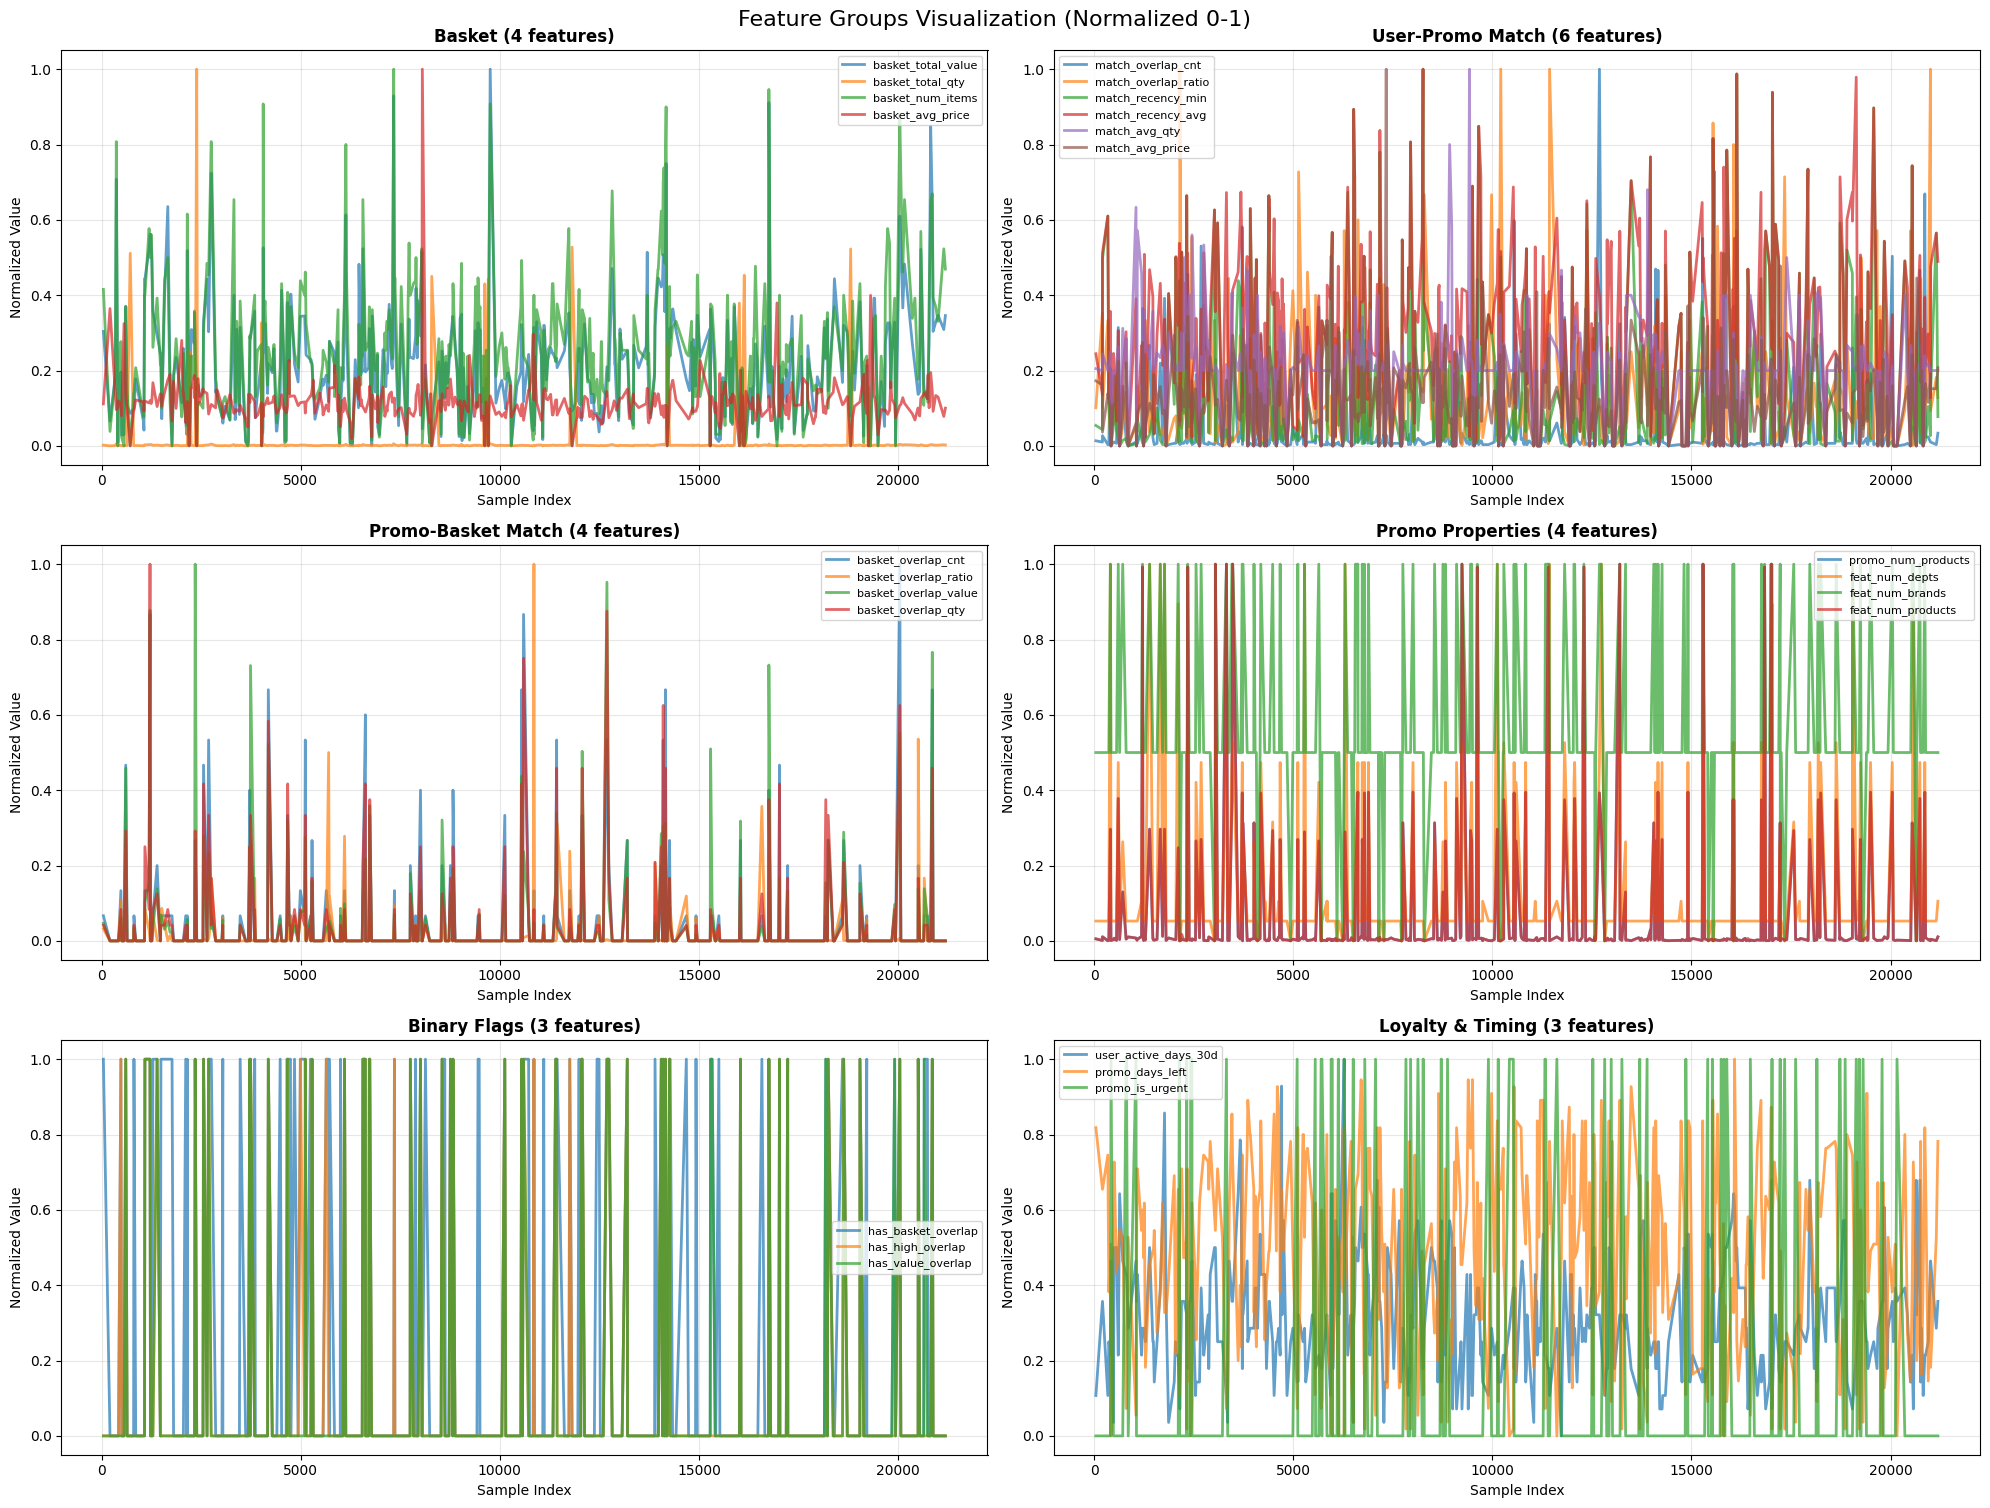

✅ Created 6 grouped plots


In [164]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CELL: Grouped Feature Plots (By Category)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

print("="*80)
print("📈 GROUPED FEATURE PLOTS")
print("="*80)

# Feature groups
feature_groups = {
    'Basket': ['basket_total_value', 'basket_total_qty', 'basket_num_items', 'basket_avg_price'],
    'User-Promo Match': ['match_overlap_cnt', 'match_overlap_ratio', 'match_recency_min',
                         'match_recency_avg', 'match_avg_qty', 'match_avg_price'],
    'Promo-Basket Match': ['basket_overlap_cnt', 'basket_overlap_ratio',
                           'basket_overlap_value', 'basket_overlap_qty'],
    'Promo Properties': ['promo_num_products', 'feat_num_depts', 'feat_num_brands', 'feat_num_products'],
    'Binary Flags': ['has_basket_overlap', 'has_high_overlap', 'has_value_overlap'],
    'Loyalty & Timing': ['user_active_days_30d', 'promo_days_left', 'promo_is_urgent']
}

# Sample data
sample_size = min(500, len(pair_df))
df_sample = pair_df.sample(n=sample_size, random_state=42).sort_index()

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
axes = axes.flatten()

for idx, (group_name, features) in enumerate(feature_groups.items()):
    ax = axes[idx]

    # Filter existing features
    existing_features = [f for f in features if f in df_sample.columns]

    if not existing_features:
        ax.text(0.5, 0.5, f'No features in\n{group_name}',
                ha='center', va='center', fontsize=12)
        ax.set_title(group_name)
        continue

    # Normalize
    df_norm = pd.DataFrame(
        MinMaxScaler().fit_transform(df_sample[existing_features]),
        columns=existing_features,
        index=df_sample.index
    )

    # Plot
    for col in existing_features:
        ax.plot(df_norm.index, df_norm[col], label=col, alpha=0.7, linewidth=2)

    ax.set_title(f'{group_name} ({len(existing_features)} features)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Sample Index', fontsize=10)
    ax.set_ylabel('Normalized Value', fontsize=10)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Feature Groups Visualization (Normalized 0-1)',
             fontsize=16, y=1.002)
plt.show()

print(f"✅ Created 6 grouped plots")

📊 SEPARATED FEATURE PLOTS
Plotting with 1000 samples...


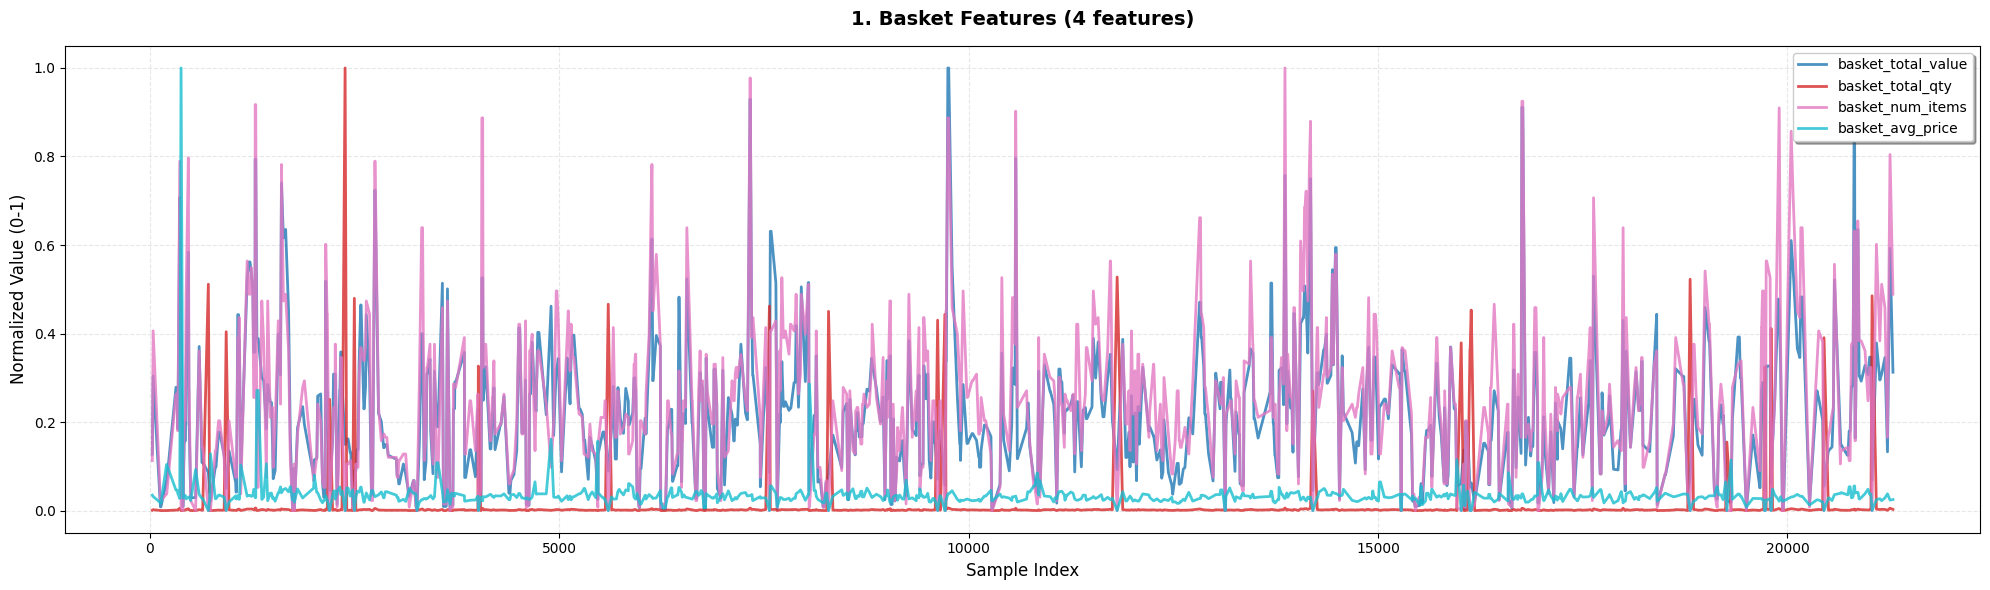

✅ 1. Basket Features: 4 features plotted


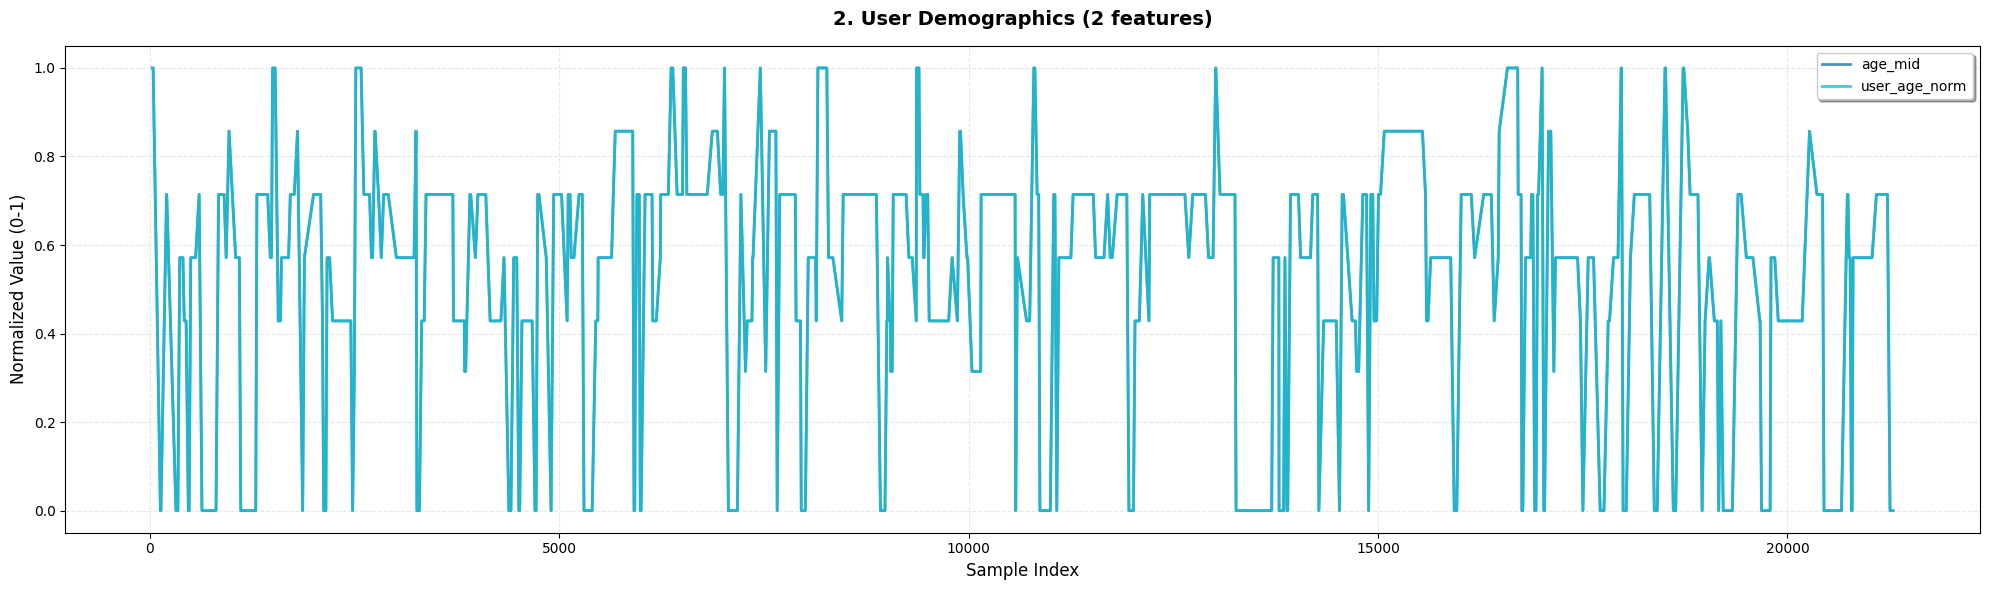

✅ 2. User Demographics: 2 features plotted


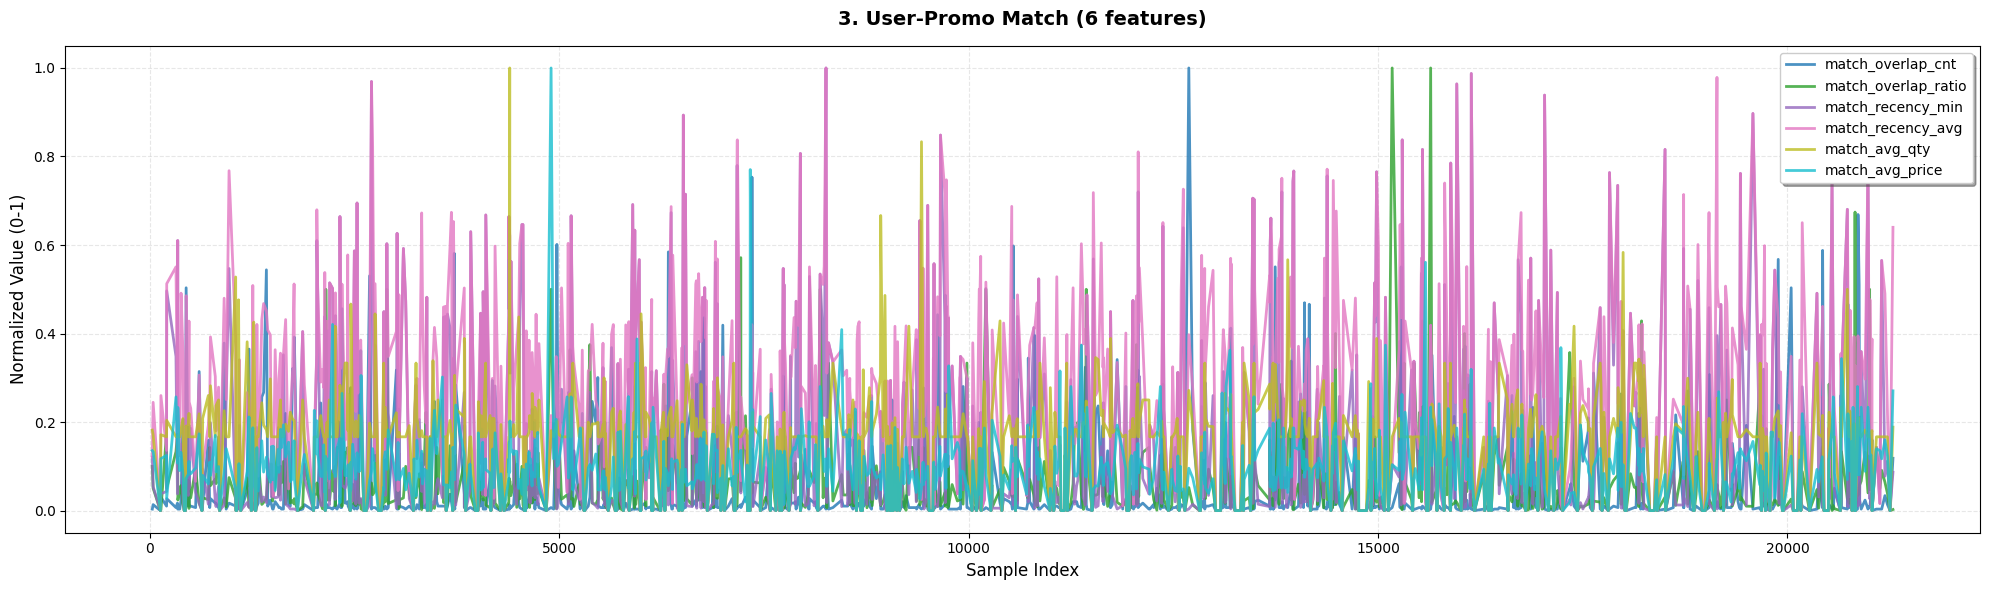

✅ 3. User-Promo Match: 6 features plotted


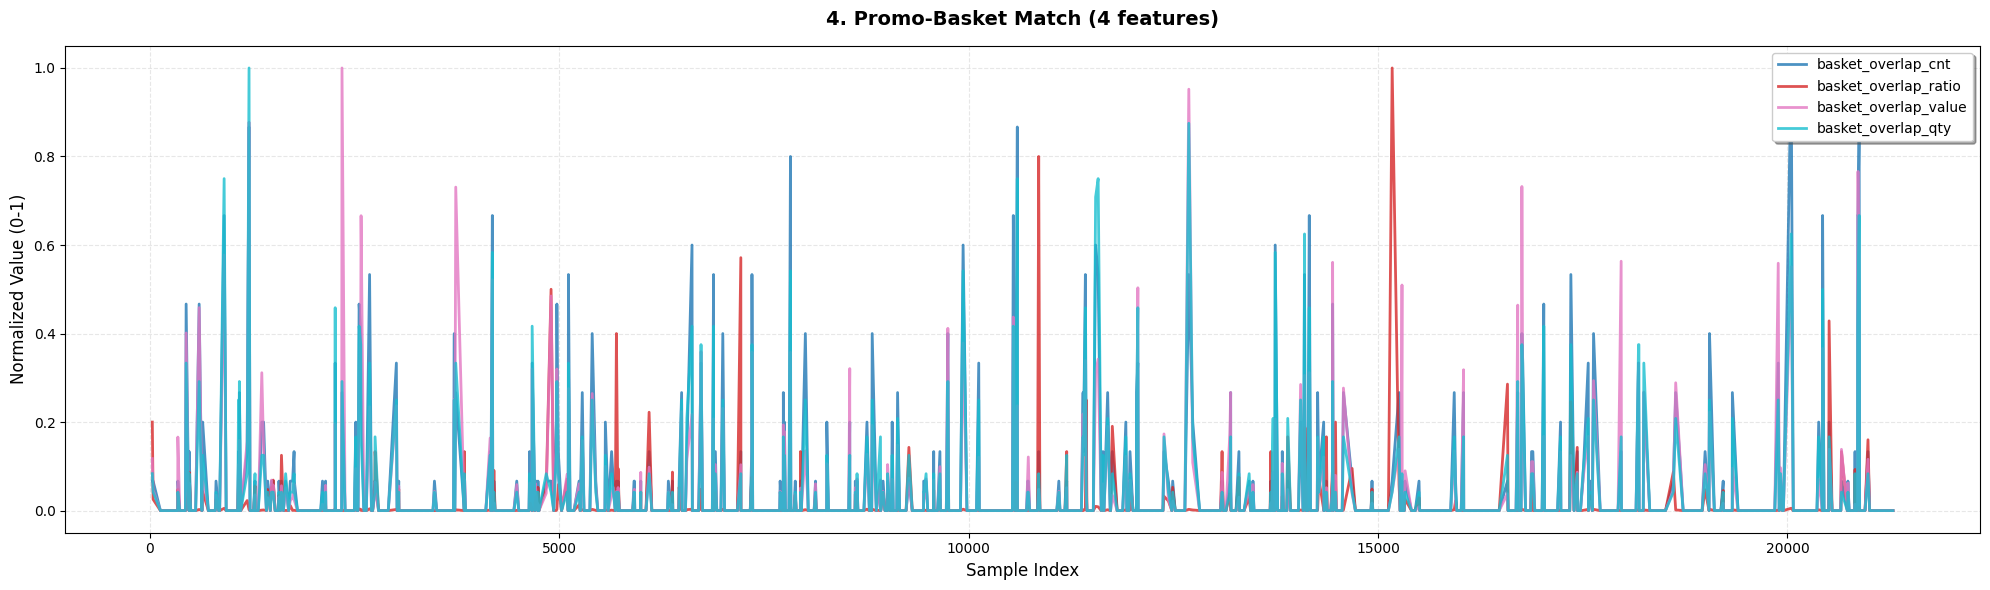

✅ 4. Promo-Basket Match: 4 features plotted


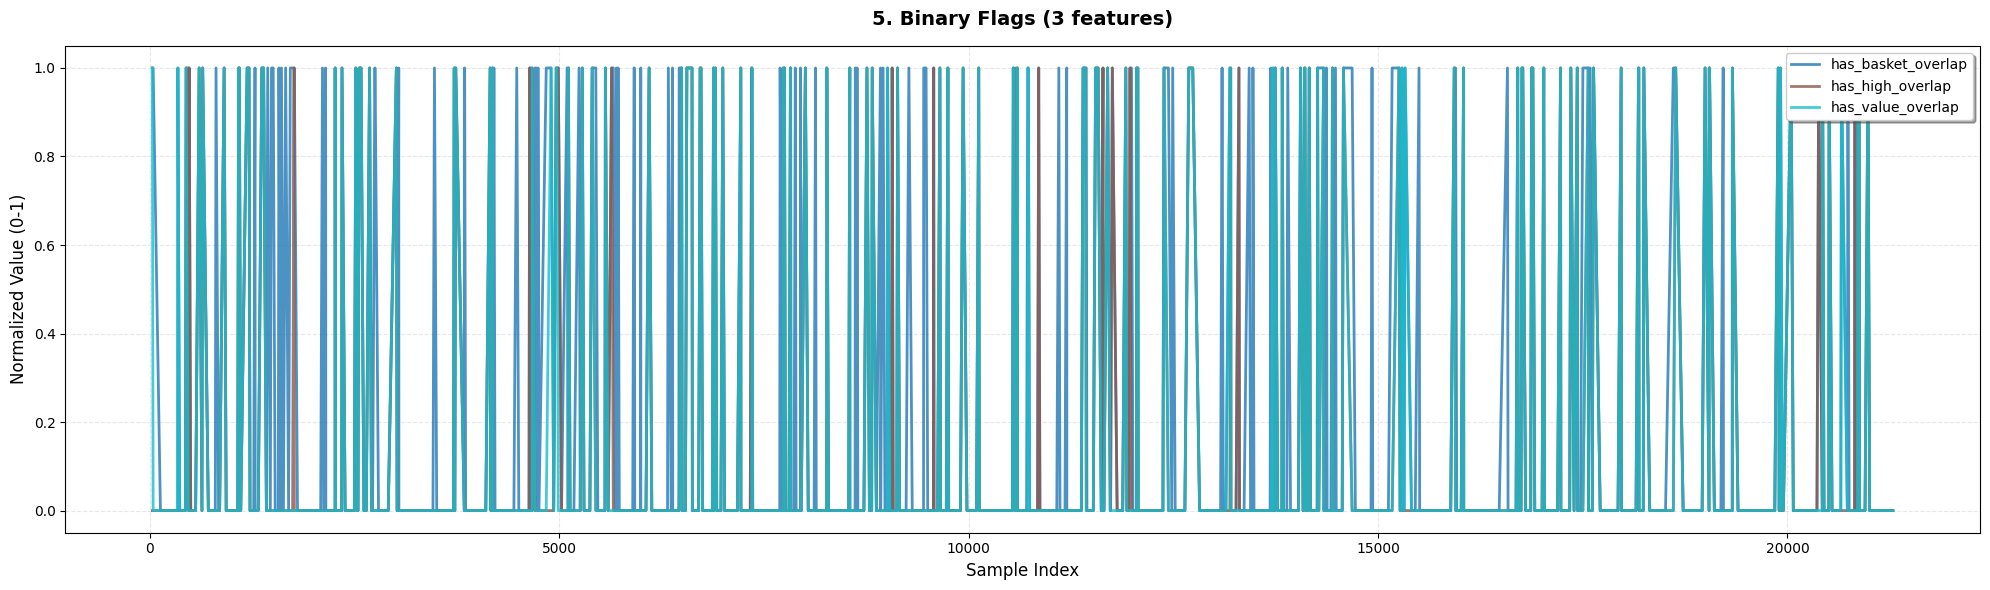

✅ 5. Binary Flags: 3 features plotted


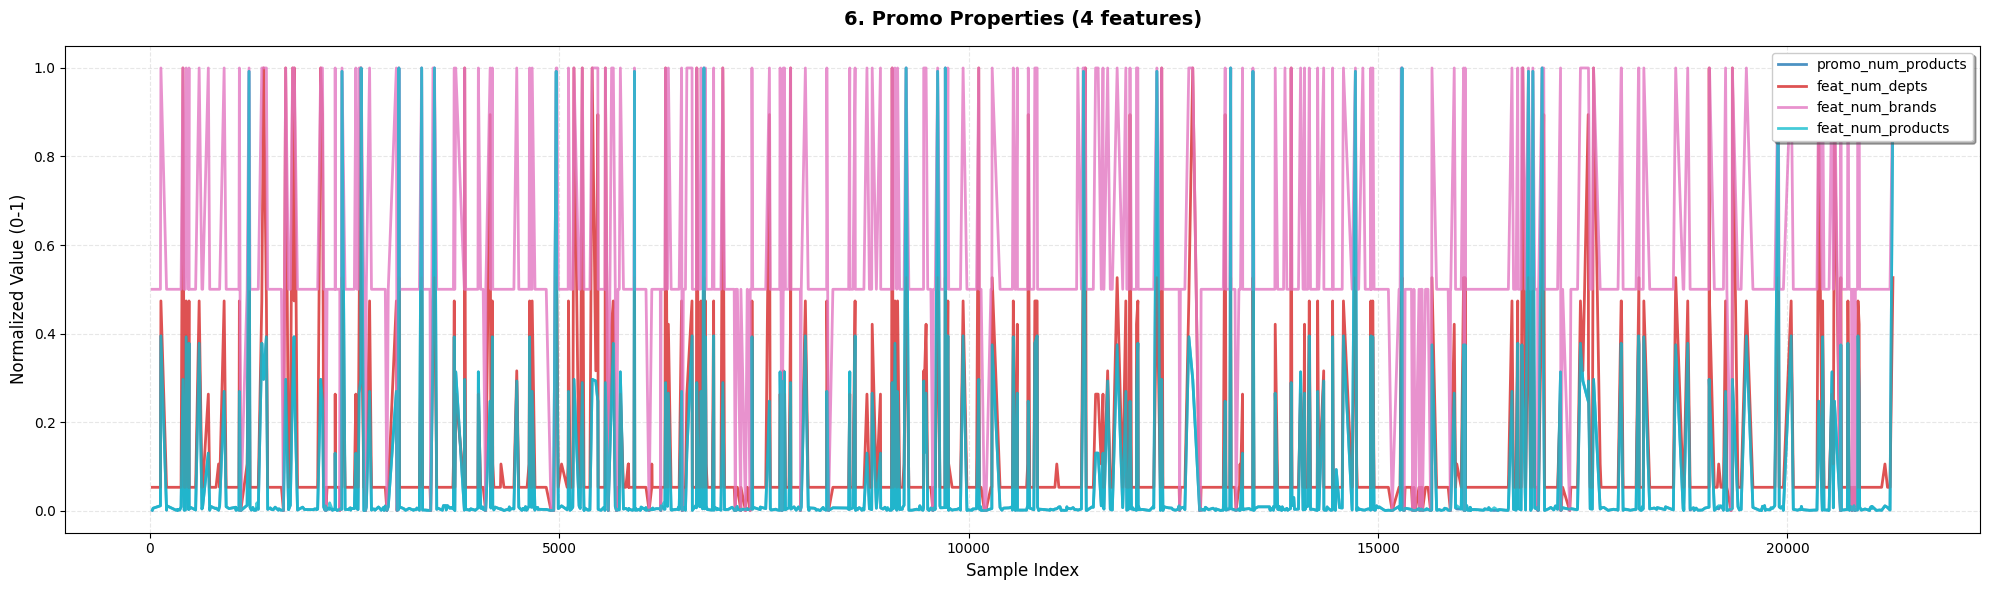

✅ 6. Promo Properties: 4 features plotted


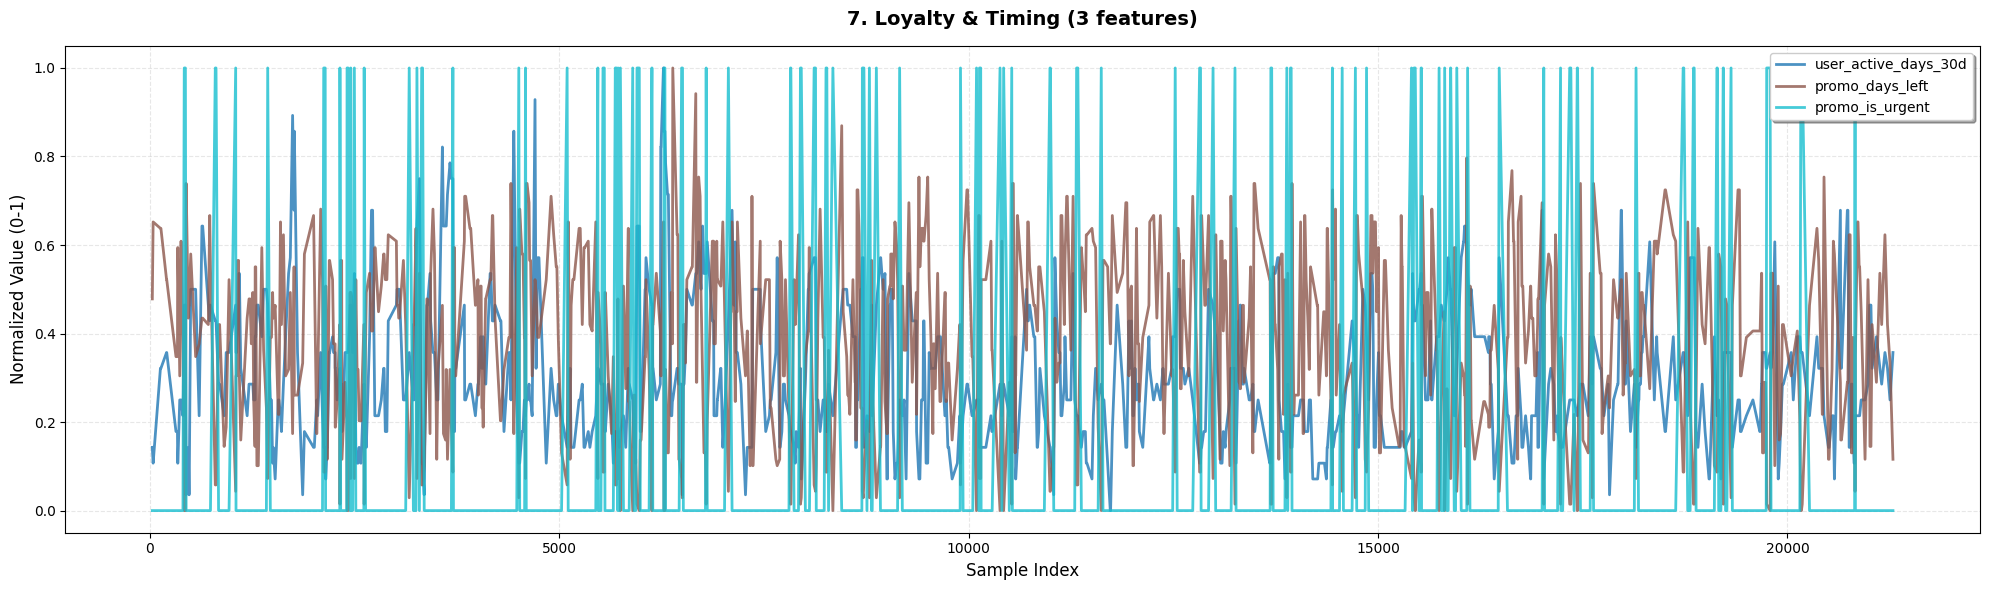

✅ 7. Loyalty & Timing: 3 features plotted

✅ ALL PLOTS COMPLETED


In [165]:
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# CELL: Separated Feature Plots (แยกตาม Group)
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("="*80)
print("📊 SEPARATED FEATURE PLOTS")
print("="*80)

# Feature groups
feature_groups = {
    '1. Basket Features': [
        'basket_total_value', 'basket_total_qty',
        'basket_num_items', 'basket_avg_price'
    ],
    '2. User Demographics': [
        'age_mid', 'user_age_norm'
    ],
    '3. User-Promo Match': [
        'match_overlap_cnt', 'match_overlap_ratio',
        'match_recency_min', 'match_recency_avg',
        'match_avg_qty', 'match_avg_price'
    ],
    '4. Promo-Basket Match': [
        'basket_overlap_cnt', 'basket_overlap_ratio',
        'basket_overlap_value', 'basket_overlap_qty'
    ],
    '5. Binary Flags': [
        'has_basket_overlap', 'has_high_overlap', 'has_value_overlap'
    ],
    '6. Promo Properties': [
        'promo_num_products', 'feat_num_depts',
        'feat_num_brands', 'feat_num_products'
    ],
    '7. Loyalty & Timing': [
        'user_active_days_30d', 'promo_days_left', 'promo_is_urgent'
    ]
}

# Sample data
sample_size = min(1000, len(pair_df))
df_sample = pair_df.sample(n=sample_size, random_state=42).sort_index()

print(f"Plotting with {sample_size} samples...")

# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
# Plot each group separately
# ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

for group_name, features in feature_groups.items():
    # Filter existing features
    existing_features = [f for f in features if f in df_sample.columns]

    if not existing_features:
        print(f"⚠️  {group_name}: No features found")
        continue

    # Normalize
    df_norm = pd.DataFrame(
        MinMaxScaler().fit_transform(df_sample[existing_features]),
        columns=existing_features,
        index=df_sample.index
    )

    # Create figure
    plt.figure(figsize=(20, 6))

    # Generate colors
    colors = plt.cm.tab10(np.linspace(0, 1, len(existing_features)))

    # Plot each feature
    for i, col in enumerate(existing_features):
        plt.plot(df_norm.index, df_norm[col],
                label=col, alpha=0.8, linewidth=2, color=colors[i])

    # Styling
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Normalized Value (0-1)', fontsize=12)
    plt.title(f'{group_name} ({len(existing_features)} features)',
              fontsize=14, fontweight='bold', pad=15)
    plt.legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.ylim(-0.05, 1.05)

    plt.tight_layout()
    plt.show()

    print(f"✅ {group_name}: {len(existing_features)} features plotted")

print("\n" + "="*80)
print("✅ ALL PLOTS COMPLETED")
print("="*80)

In [166]:
pair_df.to_csv('features_all4.csv', index=False)

In [170]:
pair_df.columns

Index(['household_key', 'BASKET_ID', 'PROMO_KEY', 'label', 'qid',
       'basket_total_value', 'basket_total_qty', 'basket_num_items',
       'basket_avg_price', 'basket_products', 'age_mid', 'user_age_norm',
       'day_t', 'match_overlap_cnt', 'match_overlap_ratio',
       'match_recency_min', 'match_recency_avg', 'match_avg_qty',
       'match_avg_price', 'basket_overlap_cnt', 'basket_overlap_ratio',
       'basket_overlap_value', 'basket_overlap_qty', 'has_basket_overlap',
       'has_high_overlap', 'has_value_overlap', 'promo_num_products',
       'feat_num_depts', 'feat_num_brands', 'feat_num_products',
       'user_active_days_30d', 'promo_days_left', 'promo_is_urgent'],
      dtype='object')

In [167]:
pair_df.iloc[:10]

household_key    BASKET_ID      PROMO_KEY  label            qid  \
0             1  33192346254  54154888076|8      0  1_33192346254   
1             1  33192346254  55100012140|8      0  1_33192346254   
2             1  33192346254  10000085364|8      1  1_33192346254   
3             1  33192346254  10000089020|8      0  1_33192346254   
4             1  33192346254  10000085362|8      0  1_33192346254   
5             1  33192346254  54100024950|8      0  1_33192346254   
6             1  33192346254  53800050033|8      0  1_33192346254   
7             1  33192346254  54200000033|8      0  1_33192346254   
8             1  33192346254  53600000078|8      0  1_33192346254   
9             1  33192346254  10000089024|8      0  1_33192346254   

   basket_total_value  basket_total_qty  basket_num_items  basket_avg_price  \
0               85.95                41                33          2.096341   
1               85.95                41                33          2.096341   
2               85.95                41                33          2.096341   
3               85.95                41                33          2.096341   
4               85.95                41                33          2.096341   
5               85.95                41                33          2.096341   
6               85.95                41                33          2.096341   
7               85.95                41                33          2.096341   
8               85.95                41                33          2.096341   
9               85.95                41                33          2.096341   

                                     basket_products  ...  has_basket_overlap  \
0  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   0   
1  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   0   
2  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   1   
3  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   0   
4  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   1   
5  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   0   
6  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   0   
7  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   0   
8  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   0   
9  {852662, 13672182, 1050310, 931136, 1006546, 1...  ...                   0   

   has_high_overlap  has_value_overlap  promo_num_products  feat_num_depts  \
0                 0                  0                  85               2   
1                 0                  0                  58               2   
2                 1                  1                1881               6   
3                 0                  0                  72               2   
4                 0                  0                3580              18   
5                 0                  0                  12               2   
6                 0                  0                 154               2   
7                 0                  0                  10               2   
8                 0                  0                  12               2   
9                 0                  0                  24               2   

   feat_num_brands  feat_num_products  user_active_days_30d  promo_days_left  \
0                2                 85                     2               39   
1                2                 58                     2               39   
2                3               1881                     2               39   
3                2                 72                     2               39   
4                3               3580                     2               39   
5                2                 12                     2               39   
6                2                154                     2  

In [171]:
sample_features3 = pair_df.iloc[:10]

In [172]:
sample_features3.to_csv('sample_features3.csv', index=False)